# Эксперименты и построение моделей

В данном ноутбуке представлены этапы построения моделей для распознавания звуковых сигналов азбуки Морзе.

Здесь также находятся все основные функции, используемые на разных этапах пайплайна: предобработка данных, обучение модели, декодирование и предсказание.

Работа велась поэтапно, остались удачные эксперименты и не очень. Заголовки служат для навигации по полноценным экспериментам с обучениями моделей. <br>
Для переключения сразу на успешные и последние результаты — [начните с Boost, prune & more cnn](#boost-prune--more-cnn)

## Preparing & loading

In [1]:
import copy
from functools import partial
import json
import os
from pathlib import Path
import sys
from typing import Callable, Dict, List, Optional, Tuple, Union

from dotenv import load_dotenv
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import optuna
from optuna.integration.mlflow import MLflowCallback
from optuna.samplers import TPESampler
import pandas as pd
from scipy.signal import wiener
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pad_sequence
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
import torchaudio
from torchaudio.functional import edit_distance
from torchaudio.models.decoder import ctc_decoder
from tqdm import tqdm


In [1]:
# import importlib
# import config

# importlib.reload(config)

In [2]:
sys.path.append("../src")

from config import (
    DATA_DIR,
    AUDIO_FILES_DIR,
    SEED,
    MODELS_DIR,
    MODELS_INFO_PATH,
    EXPERIMENT_NAME,
    STUDY_DB_URI,
)

np.random.seed(SEED)
MODELS_INFO_PATH

WindowsPath('C:/Users/user/Desktop/Jupyter_and_projects/test_kontur/morse_decoder/mlflow_server/mlartifacts/models_info.json')

### Mlflow run

Запуск mlflow сервера для логирования

In [3]:
load_dotenv()

TRACKING_SERVER_HOST = os.getenv("TRACKING_SERVER_HOST")
TRACKING_SERVER_PORT = os.getenv("TRACKING_SERVER_PORT")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

# mlflow.create_experiment(EXPERIMENT_NAME)

print("Connected to MLflow server:", mlflow.get_tracking_uri())

Connected to MLflow server: http://127.0.0.1:8080


### Функции для обучения модели

В этом разделе собраны основные функции, используемые в дальнейшем для обучения модели. <br>
Если в каких-либо следующих разделах используется изменённый вариант функции, он представлен отдельно под другим именем прямо в соответствующем разделе.

Получение словаря

In [41]:
def get_vocab(words: pd.Series, blank: str = "<blk>") -> dict[int, str]:
    """
    Строит словарь всех уникальных символов, встречающихся в целевом признаке.
    Начальные индексы зарезервированы для служебных символов.
    """
    vocab = {0: blank, 1: "|"}
    all_chars = set("".join(words.astype(str)))

    for i, char in enumerate(sorted(all_chars), start=2):
        vocab[i] = char

    print(f"Vocab is ready, size = {len(vocab)}")
    return vocab

Предобработка аудио файлов с кэшированием полученных файлов.

In [42]:
def path_to_melspect_cached(
    file_name: str,
    audio_files_dir: Path,
    cache_dir: Path,
    overwrite: bool = False,
) -> np.ndarray:
    """
    Из списка файлов возвращает мел-спектрограмму в dB для заданного аудиофайла.
    Использует кэширование, чтобы избежать повторной обработки.
    """
    cache_path = cache_dir / (file_name.replace(".opus", ".npy"))

    if cache_path.exists() and not overwrite:
        return np.load(cache_path)

    waveform, sr = torchaudio.load(audio_files_dir / file_name)

    mel = torchaudio.transforms.MelSpectrogram(
        sample_rate=sr, n_fft=1024, hop_length=256, n_mels=80
    )(waveform)
    mel_db = torchaudio.transforms.AmplitudeToDB(top_db=80)(mel)
    mel_db = mel_db.squeeze(0).cpu().numpy()

    os.makedirs(cache_dir, exist_ok=True)
    np.save(cache_path, mel_db)
    return mel_db

Tokenizer для перевода символов в индексы и наоборот

In [43]:
class Tokenizer:
    """
    Класс для кодирования и декодирования строк на основе словаря символов.
    """

    def __init__(self, vocab: Dict[int, str]):
        self.index_char = vocab
        self.char_index = {char: index for index, char in self.index_char.items()}

    def __call__(
        self, chars: Union[str, List[str]]
    ) -> Union[List[int], List[List[int]]]:
        """
        Преобразует строку или список строк в список индексов.
        """
        if isinstance(chars, str):
            return [self.char_index.get(char, -1) for char in chars]
        elif isinstance(chars, list):
            return [self.__call__(t) for t in chars]
        else:
            raise ValueError("Expected list or str")

    def decode(
        self, indexs: Union[List[int], List[List[int]]]
    ) -> Union[str, List[str]]:
        """
        Преобразует список индексов или список списков индексов обратно в строку(и).
        """
        if isinstance(indexs, list):
            if isinstance(indexs[0], list):
                return [self.decode(i) for i in indexs]
            else:
                return "".join([self.index_char.get(idx, "") for idx in indexs])
        else:
            raise ValueError("Expected list or str")

Готовая функция для перевода выходов модели в конечный набор символов

In [44]:
def decoding_to_tokens(
    decoder: Callable,
    model_output: torch.Tensor,
    tokenizer: Callable,
) -> List[str]:
    """
    Применяет декодер(beam_search) и tokenizer к выходу модели и возвращает расшифрованные строки.
    """

    log_probs = nn.functional.log_softmax(model_output, dim=-1)
    results = decoder(log_probs.contiguous())  # log_probs: [B, T, C]

    decoded_sequences = []
    for batch_result in results:
        top_hypo = batch_result[0]
        tokens = top_hypo.tokens.tolist()
        decoded_sequence = tokenizer.decode(tokens)
        decoded_sequence = decoded_sequence.strip("|")
        decoded_sequences.append(decoded_sequence)

    return decoded_sequences

Адаптация nn.CTCLoss под нашу задачу

In [45]:
def loss_ctc(
    model_output: torch.Tensor,  # Тензор [Batch, Time, Classes] - ожидается на device
    targets: torch.Tensor,  # Тензор [sum(target_lengths)] - ожидается на CPU
    target_lengths: torch.Tensor,  # Тензор [B] - ожидается на CPU
    blank_id: int = 0,
) -> torch.Tensor:
    """
    Вычисляет CTC-лосс (Connectionist Temporal Classification) между выходом модели и целевыми метками.

    """
    log_output = F.log_softmax(model_output, dim=-1)
    log_output = log_output.transpose(0, 1)

    output_time_dim = log_output.shape[0]  # T'
    batch_size = log_output.shape[1]  # B

    output_lengths = torch.full(
        size=(batch_size,), fill_value=output_time_dim, dtype=torch.long, device="cpu"
    )
    targets_cpu = targets.cpu()
    target_lengths_cpu = target_lengths.cpu()

    loss = nn.CTCLoss(blank=blank_id, reduction="mean", zero_infinity=True)

    batch_loss = loss(
        log_output.float(), targets_cpu, output_lengths, target_lengths_cpu
    )
    return batch_loss

Класс Dataset, принимающий имена файлов, transform для предобработки этих файлов и tokenizer для подготовки target

In [46]:
class MorseDataset(Dataset):
    """
    Класс для загрузки и обработки датасета

    Атрибуты:
        X_filenames (pd.Series): Список путей к аудио файлам.
        y_texts (Optional[pd.Series]): Список целевых меток (строки).
        transform (Optional[Callable]): Функция для преобразования аудио файлов в признаки.
        tokenizer (Optional[Callable[[str], list]]): Tokenizer для преобразования текста в индексы.
    """

    def __init__(
        self,
        X_filenames: pd.Series,
        y_texts: Optional[pd.Series] = None,
        transform: Optional[Callable] = None,
        tokenizer: Optional[Callable[[str], list]] = None,
    ):
        self.X_filenames = X_filenames.reset_index(drop=True)
        self.y_texts = y_texts.reset_index(drop=True) if y_texts is not None else None
        self.transform = transform
        self.tokenizer = tokenizer

    def __len__(self) -> int:
        return len(self.X_filenames)

    def __getitem__(self, idx) -> Dict[str, torch.Tensor]:
        filename = self.X_filenames[idx]
        mel_features = self.transform(filename)  # [C, T] ([n_mels, time])

        item = {"input": torch.tensor(mel_features, dtype=torch.float)}

        if self.y_texts is not None:
            text = self.y_texts[idx]
            if self.tokenizer:
                target = self.tokenizer(text)
            else:
                raise ValueError("Tokenizer needs for target encoding")
            item["target_text"] = text
            item["target"] = torch.tensor(target, dtype=torch.long)
            item["target_length"] = len(target)

        return item

Функции для создания DataLoader с кастомным collate_fn для создания удобного batch при работе с CTCLoss

In [ ]:
def dataloader_collate(batch: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
    """
    Функция для объединения элементов батча, с добавлением паддинга для последовательностей.
    """
    inputs = [item["input"].T for item in batch]  # [T, C]

    padded_inputs = pad_sequence(inputs, batch_first=True)  # [B, max_T, C]
    padded_inputs = padded_inputs.transpose(1, 2)  # [B, C, T]

    collated = {
        "input": padded_inputs,
    }

    if "target" in batch[0]:
        targets = torch.cat([item["target"] for item in batch], dim=0)
        target_lengths = torch.tensor(
            [item["target_length"] for item in batch], dtype=torch.long
        )
        collated["target_text"] = [item["target_text"] for item in batch]
        collated["target"] = targets
        collated["target_length"] = target_lengths

    return collated


def data_loader(
    dataset: torch.utils.data.Dataset,
    batch_size: int,
    shuffle: bool,
    num_workers: int = 0,
    drop_last: bool = True,
) -> DataLoader:
    """
    Функция для создания DataLoader с заданными параметрами.
    """
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=dataloader_collate,
        num_workers=num_workers,
        drop_last=drop_last,
        pin_memory=True,
    )

Основная функция для обучения модели и валидации результатов. <br>
Для обучения используется CTC-loss. Валидация проводится с использованием beam-search декодирования, <br>
после чего рассчитывается расстояние Левенштейна между предсказанным и истинным текстом.<br>

In [48]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    ctc_loss: Callable,
    epochs: int,
    metric: Callable,
    decoder: Callable,
    tokenizer: Callable,
    val_loader: Union[DataLoader, None] = None,
    scheduler: Union[Callable, None] = None,
) -> Tuple[nn.Module, Dict[str, List]]:
    """
    Обучение модели с CTC-loss, возможной валидацией и логированием метрик по эпохам.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model.to(device, non_blocking=True)
    metrics = {"train_loss": [], "train_metric": [], "val_metric": []}

    for epoch in range(epochs):
        print(f"\n Epoch {epoch + 1}/{epochs}")
        epoch_loss = []
        # epoch_train_metrics = []
        model.train()
        with tqdm(
            train_loader, desc="Training", total=len(train_loader), dynamic_ncols=True
        ) as pbar:
            for batch in pbar:
                inputs = batch["input"].to(device, non_blocking=True)  # (B, C, T)
                targets = batch["target"]  # (sum_target_len,)
                target_lengths = batch["target_length"]  # (B,)
                optimizer.zero_grad()

                # with autocast(device_type=device.type):
                output = model(inputs)
                loss = ctc_loss(output, targets, target_lengths)

                # scaler.scale(loss).backward()
                # scaler.step(optimizer)
                # scaler.update()
                loss.backward()
                clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                epoch_loss.append(loss.item())

        # emissions = output.detach().cpu().float()
        # tokens_output = decoding_to_tokens(decoder, emissions, tokenizer)
        # batch_train_metrics = [
        #     metric(pred, gt) for pred, gt in zip(tokens_output, target_text)
        # ]
        # epoch_train_metrics.append(np.mean(batch_train_metrics))

        avg_epoch_loss = np.mean(epoch_loss)
        metrics["train_loss"].append(avg_epoch_loss)

        # avg_epoch_train_metric = np.mean(epoch_train_metrics)
        # metrics["train_metric"].append(avg_epoch_train_metric)

        print(
            f"Epoch {epoch + 1} with loss = {avg_epoch_loss:.4f}"  # and metric_train={avg_epoch_train_metric:.4f}"
        )
        if scheduler is not None:
            scheduler.step()
            print(f"Learning_rate = {scheduler.get_last_lr()}")

        if val_loader is not None:
            model.eval()
            epoch_val_metrics = []

            with torch.no_grad():
                for batch in tqdm(
                    val_loader, desc=f"Validation Epoch {epoch + 1}", leave=False
                ):
                    inputs = batch["input"].to(device, non_blocking=True)  # (B, C, T)
                    target_text = batch["target_text"]
                    # with autocast(device_type=device.type):
                    predictions = model(inputs)

                    emissions = predictions.detach().cpu().float()

                    tokens_output = decoding_to_tokens(decoder, emissions, tokenizer)
                    batch_val_metrics = [
                        metric(pred, gt) for pred, gt in zip(tokens_output, target_text)
                    ]
                    epoch_val_metrics.append(np.mean(batch_val_metrics))

            avg_epoch_val_metrics = np.mean(epoch_val_metrics)
            metrics["val_metric"].append(avg_epoch_val_metrics)
            print(f"Val Metric={avg_epoch_val_metrics:.4f}")

        else:
            metrics["val_metric"].append(None)

    return model, metrics

Блоки для создания модели - сверточный блок и LSTM-блок

In [49]:
class ConvBlock(nn.Module):
    """
    Свёрточный блок с нормализацией и активацией ReLU.

    Включает свёртку (Conv1d), слой нормализации (LayerNorm) и активацию ReLU.
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        padding: int,
        stride: int = 1,
        groups: int = 1,
    ):
        super().__init__()
        self.conv = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            padding=padding,
            stride=stride,
            groups=groups,
        )
        self.norm = nn.LayerNorm(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.norm(x.transpose(1, 2)).transpose(1, 2)
        return self.relu(x)


class LstmBlock(nn.Module):
    """
    Блок LSTM с нормализацией и dropout.

    Включает двустороннюю LSTM (2 слоя), слой нормализации (LayerNorm) и слой dropout.
    """

    def __init__(self, input_size: int, hidden_size: int, dropout: float = 0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
        )
        self.norm = nn.LayerNorm(hidden_size * 2)
        self.drop = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x, _ = self.lstm(x)
        x = self.drop(self.norm(x))
        return x

Класс модели - бэйзлана.

In [50]:
class ModelBase(nn.Module):
    """
    Базовая модель на основе свёрточный блок (ConvBlock),
    LSTM блок (LstmBlock) и слой классификации (Linear).
    """

    def __init__(
        self,
        input_size: Tuple[int, int],
        kernel_chanel: int,
        conv_out_size: int,
        vocab_size: int,
    ):
        super().__init__()

        self.conv_part = nn.Sequential(
            ConvBlock(
                in_channels=input_size[0],
                out_channels=kernel_chanel,
                kernel_size=5,
                padding=2,
                stride=2,
            ),
        )

        self.rnn_part = nn.Sequential(
            LstmBlock(input_size=kernel_chanel, hidden_size=64, dropout=0.4)
        )

        self.clf = nn.Linear(
            in_features=64 * 2,
            out_features=vocab_size,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_part(x)
        x = x.transpose(1, 2)
        x = self.rnn_part(x)
        return self.clf(x)

Инициализация начальных весов модели в зависимости от блока.

In [51]:
def init_weights(module: nn.Module) -> None:
    """
    Инициализация весов для различных типов слоёв.
    """
    if isinstance(module, nn.Conv1d):
        init.kaiming_normal_(module.weight, nonlinearity="relu")
        if module.bias is not None:
            init.constant_(module.bias, 0)

    elif isinstance(module, nn.Linear):
        init.xavier_uniform_(module.weight)
        if module.bias is not None:
            init.constant_(module.bias, 0)

    elif isinstance(module, nn.LSTM):
        for name, param in module.named_parameters():
            if "weight_ih" in name:
                init.xavier_uniform_(param)
            elif "weight_hh" in name:
                init.orthogonal_(param)
            elif "bias" in name:
                init.constant_(param, 0)

    elif isinstance(module, nn.LayerNorm):
        if module.elementwise_affine:
            init.constant_(module.weight, 1.0)
            init.constant_(module.bias, 0.0)

Отрисовка словаря с метриками, полученного после функции train_model()

In [52]:
def plot_metrics(
    metrics_dict: dict,
    title: str = "Model Metrics",
    xlabel: str = "Epochs",
    ylabel: str = "Metric Value",
) -> None:
    """
    Функция для отображения метрик в виде графиков.
    """
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(list(metrics_dict.values())[0]) + 1)

    for metric_name, metric_values in metrics_dict.items():
        if metric_values:
            plt.plot(epochs, metric_values, label=metric_name)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Функция для предсказания - получает список имен файлов, прогоняет через модель, через decoder и tokenizer и отдает полученные готовые предсказания.

In [53]:
def model_predict(
    model: nn.Module,
    test_paths: pd.Series,
    tokenizer: Tokenizer,
    decoder: Callable,
    batch_size: int = 32,
    device: Optional[torch.device] = None,
) -> pd.DataFrame:
    """
    Функция для предсказания модели на тестовых данных.

    Parameters:
        model (nn.Module): Обученная модель для предсказаний.
        test_paths (pd.Series): Имена тестовых аудиофайлов.
        tokenizer (Tokenizer): Tokenizer для декодирования индексов.
        decoder(Callable): Декодер для преобразования выходов модели в индексы словаря.
        batch_size (int): Размер батча для DataLoader.
        device (torch.device): Устройство (CPU или CUDA), на котором будет происходить вычисление.

    Returns:
        pd.DataFrame: DataFrame с декодированными предсказаниями.
    """

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.eval()

    # Преобразование тестовых данных в датасет
    test_dataset = MorseDataset(
        X_filenames=test_paths, transform=transform, tokenizer=tokenizer
    )

    # Создание DataLoader
    test_loader = data_loader(
        test_dataset, batch_size=batch_size, shuffle=False, drop_last=False
    )

    predictions = []

    with torch.no_grad():
        with tqdm(test_loader, desc="Predicting", total=len(test_loader)) as pbar:
            for batch in pbar:
                inputs = batch["input"].to(device)  # [B, C, T]

                outputs = model(inputs)

                decoded_preds = decoding_to_tokens(decoder, outputs, tokenizer)

                predictions.extend(decoded_preds)

                pbar.set_postfix({"Predictions": len(predictions)})

    return pd.DataFrame({"id": test_paths, "message": predictions})

Функция для сохранения метрик и моделей.

In [ ]:
def save_model_metrics(
    model: nn.Module,
    metrics: Dict[str, list],
    model_path: Path,
    metric_filename: str,
) -> None:
    """
    Сохраняет модель и метрики в указанные файлы.
    """
    torch.save(model, model_path)

    clean_metrics = {key: [float(v) for v in values] for key, values in metrics.items()}

    with open(f"{MODELS_DIR}/{metric_filename}", "w") as fd:
        json.dump(clean_metrics, fd)
        pass

Функция для логирования результатов в MlFlow

In [ ]:
def log_to_mlflow_torch(
    run_name: str,
    train_params: dict,
    metrics: dict,
    metadata: Union[dict, None] = None,
    registry_model_name: Union[str, None] = None,
    fitted_model: Union[torch.nn.Module, None] = None,
    artifact_path: str = "models",
    tags: dict = None,
    model_info_path: str = MODELS_INFO_PATH,
    experiment_name: str = EXPERIMENT_NAME,
    log_model: bool = True,
) -> Dict[str, Union[str, None]]:
    """
    Логирует метрики, параметры, модель и дополнительную информацию в MLflow.
    """

    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment is None:
        raise ValueError(f"Experiment '{experiment_name}' not found.")
    experiment_id = experiment.experiment_id

    with mlflow.start_run(run_name=run_name, experiment_id=experiment_id) as run:
        run_id = run.info.run_id
        print(f"MLflow Run ID: {run_id}")

        mlflow.log_metrics(metrics)

        for section, params in train_params.items():
            if isinstance(params, dict):
                mlflow.log_params({f"{section}.{k}": v for k, v in params.items()})
            else:
                mlflow.log_param(section, params)
        if tags:
            mlflow.set_tags(tags)
        if log_model:
            print("Starting model logging to MLflow.")
            model_info = mlflow.pytorch.log_model(
                fitted_model,
                artifact_path=artifact_path,
                registered_model_name=registry_model_name,
                metadata=metadata,
                await_registration_for=60,
            )
            # Save model info
            model_info_data = {
                "model_uri": model_info.model_uri,
                "run_id": model_info.run_id,
                "model_name": registry_model_name,
                "metadata": metadata,
            }

            model_info_path = Path(model_info_path)

            if model_info_path.exists():
                with model_info_path.open("r") as f:
                    try:
                        all_models = json.load(f)
                    except json.JSONDecodeError:
                        all_models = []
            else:
                all_models = []

            all_models.append(model_info_data)

            with model_info_path.open("w") as f:
                json.dump(all_models, f, indent=4)
        else:
            model_info_data = {"run_id": run_id, "model_info": "no_logged_model"}
            print("log_model=False — model not logged.")

    return model_info_data

### Загрузка и разделения данных

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [57]:
def load_files(folder_path):
    folder = Path(folder_path)
    variables = {}

    for file_path in folder.glob("*.csv"):
        var_name = file_path.stem
        variables[var_name] = pd.read_csv(file_path)
        print(f"{var_name} downloaded")

    return variables

In [58]:
# local file
data = load_files(DATA_DIR.joinpath("raw"))

test downloaded
train downloaded


In [ ]:
# kaggle
# data = load_files(DATA_DIR)

Разделим данные на обучающую и валидационную выборки. Для валидации будет использовано 15% всего датасета

In [59]:
X_train, X_val, y_train, y_val = train_test_split(
    data["train"]["id"], data["train"]["message"], test_size=0.15, random_state=SEED
)
for df in [X_train, y_train, X_val, y_val]:
    print(len(df))

25500
25500
4500
4500


Получаем полный словарь по всему датасету

In [60]:
full_vocab = get_vocab(data["train"]["message"])

Vocab is ready, size = 46


Подготовим словарь с параметрами для обучения, кодирования и предобработки данных для последующего логирования на создания моделей.

In [61]:
train_params = {
    "model": {
        "type": "ModelBase",
        "input_size": [80, 251],
        "kernel_chanel": 128,
        "conv_out_size": 128,
        "vocab_size": 46,
        "init_weights": "init_weights()",
    },
    "optimizer": {
        "type": "Adam",
        "lr": 0.01,
    },
    "scheduler": {"step_size": "-", "gamma": "-"},
    "transform": {
        "type": "path_to_melspect_cached()",
    },
    "decoder": {
        "type": "ctc_decoder",
        "lexicon": None,
        "tokens_count": 46,
        "beam_size": 3,
        "nbest": 1,
        "blank_token": "<blk>",
    },
    "dataloader": {"batch_size": 64, "num_workers": 0},
    "training": {"epochs": 50},
}

## Baseline

### Train

Для создания бэйзлайн модели мы используем базовый класс модели, который состоит из одного сверточного блока (ConvBlock) и одного LSTM блока (LstmBlock), <br>
а также полносвязного классификатора (FF-классификатора).  <br>
В качестве предобработки данных будем использовать мел-спектрограммы с 80 мел-бинами и окном 1024.  <br>
Эта модель позволит оценить начальную производительность на данной задаче.

Инициализируем основные компоненты для создания и обучения модели, включая выбор модели, подготовку датасета, настройку функций предобработки, оптимизаторов и метрик

In [ ]:
beam_search_decoder = ctc_decoder(
    lexicon=None,
    tokens=list(full_vocab.values()),
    beam_size=3,
    nbest=1,
    blank_token="<blk>",
)

In [41]:
tokenizer = Tokenizer(vocab=full_vocab)

print(tokenizer.index_char)
print(tokenizer.char_index)

transform = partial(
    path_to_melspect_cached,
    audio_files_dir=AUDIO_FILES_DIR,
    cache_dir=Path("./mels_cache"),
)


{0: '<blk>', 1: '|', 2: ' ', 3: '#', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: 'А', 15: 'Б', 16: 'В', 17: 'Г', 18: 'Д', 19: 'Е', 20: 'Ж', 21: 'З', 22: 'И', 23: 'Й', 24: 'К', 25: 'Л', 26: 'М', 27: 'Н', 28: 'О', 29: 'П', 30: 'Р', 31: 'С', 32: 'Т', 33: 'У', 34: 'Ф', 35: 'Х', 36: 'Ц', 37: 'Ч', 38: 'Ш', 39: 'Щ', 40: 'Ъ', 41: 'Ы', 42: 'Ь', 43: 'Э', 44: 'Ю', 45: 'Я'}
{'<blk>': 0, '|': 1, ' ': 2, '#': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, 'А': 14, 'Б': 15, 'В': 16, 'Г': 17, 'Д': 18, 'Е': 19, 'Ж': 20, 'З': 21, 'И': 22, 'Й': 23, 'К': 24, 'Л': 25, 'М': 26, 'Н': 27, 'О': 28, 'П': 29, 'Р': 30, 'С': 31, 'Т': 32, 'У': 33, 'Ф': 34, 'Х': 35, 'Ц': 36, 'Ч': 37, 'Ш': 38, 'Щ': 39, 'Ъ': 40, 'Ы': 41, 'Ь': 42, 'Э': 43, 'Ю': 44, 'Я': 45}


In [ ]:
train_dataset = MorseDataset(
    X_filenames=X_train,
    y_texts=y_train,
    transform=transform,
    tokenizer=tokenizer,
)

train_loader = data_loader(
    train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=0
)

val_dataset = MorseDataset(
    X_filenames=X_val, y_texts=y_val, transform=transform, tokenizer=tokenizer
)
val_loader = data_loader(
    val_dataset, batch_size=64, shuffle=False, drop_last=True, num_workers=0
)

In [ ]:
%%time 
base_model, base_metrics = train_model(
    model=base_model,
    train_loader=train_loader,
    optimizer=optimizer,
    ctc_loss=loss_ctc,
    epochs=50,
    metric=edit_distance,
    decoder=beam_search_decoder,
    tokenizer=tokenizer,
    val_loader=val_loader,
)

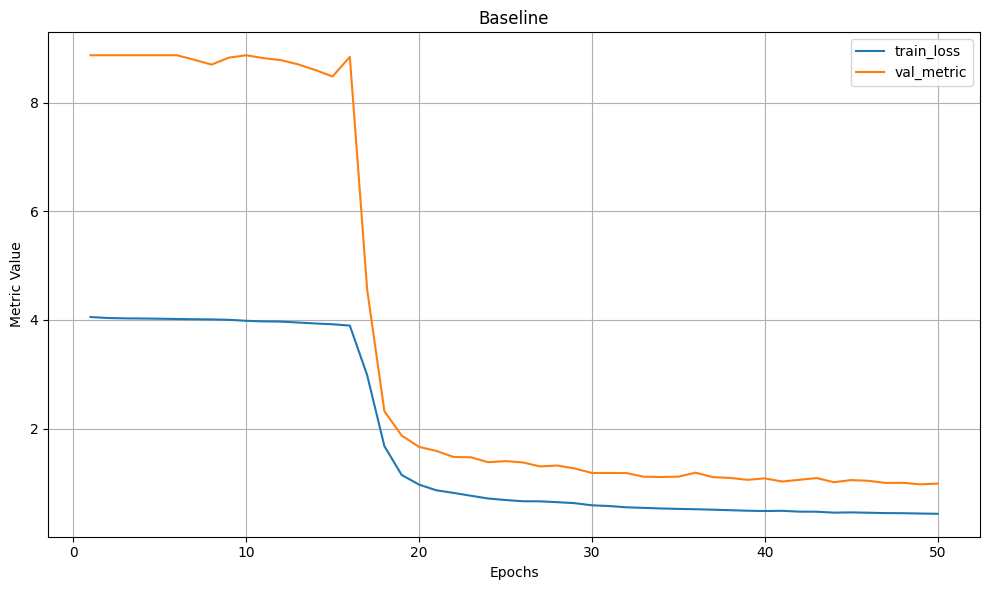

In [51]:
plot_metrics(
    base_metrics,
    "Baseline",
)

Save model

In [ ]:
base_model_path = MODELS_DIR / "base_model.pt"

save_model_metrics(base_model, base_metrics, base_model_path, "base_metrics.json")

In [ ]:
# base_model_path = MODELS_DIR / "base_model.pt"

# base_model = torch.load(base_model_path, weights_only=False)

# with open(f"{MODELS_DIR}/base_metrics.json", "r") as fd:
#           base_metrics = json.load(fd)
#           pass
# base_metrics

### Test

In [ ]:
sub = model_predict(
    model=base_model,
    test_paths=data["test"]["id"],
    tokenizer=tokenizer,
    decoder=beam_search_decoder,
    batch_size=32,
)

Predicting: 100%|██████████| 157/157 [00:16<00:00,  9.45it/s, Predictions=5000]


In [38]:
sub = sub.set_index("id")
sub.to_csv(os.path.join(DATA_DIR.joinpath("submits/base_submit.csv")))

**Бэйзлайн модель успешно обучена и показала хорошие результаты: CER на валидации составил около 1, а на части тестовых данных немного выше**

### Logging Mlflow

In [204]:
base_params = copy.deepcopy(train_params)
base_params

{'model': {'type': 'ModelBase',
  'input_size': [80, 251],
  'kernel_chanel': 128,
  'conv_out_size': 128,
  'vocab_size': 46,
  'init_weights': 'init_weights()'},
 'optimizer': {'type': 'Adam', 'lr': 0.01},
 'scheduler': {'step_size': '-', 'gamma': '-'},
 'transform': {'type': 'path_to_melspect_cached()'},
 'decoder': {'type': 'ctc_decoder',
  'lexicon': None,
  'tokens_count': 46,
  'beam_size': 3,
  'nbest': 1,
  'blank_token': '<blk>'},
 'dataloader': {'batch_size': 64, 'num_workers': 0},
 'training': {'epochs': 50}}

In [200]:
base_final_metrics = {}
for key in base_metrics:
    if len(base_metrics[key]) > 0:
        base_final_metrics[key] = round(base_metrics[key][-1], 4)
base_final_metrics


{'train_loss': 0.4303, 'val_metric': 0.9857}

In [ ]:
log_to_mlflow_torch(
    "Baseline",
    train_params=base_params,
    metrics=base_final_metrics,
    metadata={"architecture": "1 CNN, 1 RNN, 1 FC"},
    registry_model_name="baseline",
    fitted_model=base_model,
    tags={"stage": "baseline", "preprocess": "full melspectr"},
)

MLflow Run ID: ce92b624d2b642c38b982e1891a1939d
Starting model logging to MLflow.


2025/04/20 16:29:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'baseline'.
2025/04/20 16:29:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: baseline, version 1


🏃 View run Baseline at: http://127.0.0.1:8080/#/experiments/1/runs/ce92b624d2b642c38b982e1891a1939d
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


Created version '1' of model 'baseline'.


{'model_uri': 'runs:/ce92b624d2b642c38b982e1891a1939d/models',
 'run_id': 'ce92b624d2b642c38b982e1891a1939d',
 'model_name': 'baseline',
 'metadata': {'architecture': '1 CNN, 1 RNN, 1 FC'}}

## Pro Preprocessing

**В данном эксперименте сохраняем архитектуру бэйзлайн модели без изменений, но модифицируем предобработку аудио:<br> 
из исходной мел-спектрограммы оставляем лишь фрагмент, содержащий 10 мел-бинов вокруг максимального по амплитуде сигнала.**

### Train

Изменим функцию предобработки и инициализируем все необходимое

In [ ]:
def to_narrow_mel_cached(
    file_name: str,
    audio_files_dir: Path,
    cache_dir: Path,
    overwrite: bool = False,
) -> np.ndarray:
    cache_path = cache_dir / (file_name.replace(".opus", ".npy"))

    if cache_path.exists() and not overwrite:
        return np.load(cache_path)

    waveform, sr = torchaudio.load(audio_files_dir / file_name)

    mel = torchaudio.transforms.MelSpectrogram(
        sample_rate=sr, n_fft=1024, hop_length=256, n_mels=80
    )(waveform)
    mel_db = torchaudio.transforms.AmplitudeToDB(top_db=80)(mel)
    mel_db = mel_db.squeeze(0).cpu().numpy()

    peak = np.argmax(mel_db.mean(axis=1))
    start = max(peak - 5, 0)
    end = min(peak + 5, mel_db.shape[0])
    fresh_mel = mel_db[start:end]

    os.makedirs(cache_dir, exist_ok=True)
    np.save(cache_path, fresh_mel)
    return fresh_mel

In [ ]:
beam_search_decoder = ctc_decoder(
    lexicon=None,
    tokens=list(full_vocab.values()),
    beam_size=3,
    nbest=1,
    blank_token="<blk>",
)

In [40]:
tokenizer = Tokenizer(vocab=full_vocab)

print(tokenizer.index_char)
print(tokenizer.char_index)

transform = partial(
    to_narrow_mel_cached,
    audio_files_dir=AUDIO_FILES_DIR,
    cache_dir=Path("./s_mels_cache"),
)


{0: '<blk>', 1: '|', 2: ' ', 3: '#', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: 'А', 15: 'Б', 16: 'В', 17: 'Г', 18: 'Д', 19: 'Е', 20: 'Ж', 21: 'З', 22: 'И', 23: 'Й', 24: 'К', 25: 'Л', 26: 'М', 27: 'Н', 28: 'О', 29: 'П', 30: 'Р', 31: 'С', 32: 'Т', 33: 'У', 34: 'Ф', 35: 'Х', 36: 'Ц', 37: 'Ч', 38: 'Ш', 39: 'Щ', 40: 'Ъ', 41: 'Ы', 42: 'Ь', 43: 'Э', 44: 'Ю', 45: 'Я'}
{'<blk>': 0, '|': 1, ' ': 2, '#': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, 'А': 14, 'Б': 15, 'В': 16, 'Г': 17, 'Д': 18, 'Е': 19, 'Ж': 20, 'З': 21, 'И': 22, 'Й': 23, 'К': 24, 'Л': 25, 'М': 26, 'Н': 27, 'О': 28, 'П': 29, 'Р': 30, 'С': 31, 'Т': 32, 'У': 33, 'Ф': 34, 'Х': 35, 'Ц': 36, 'Ч': 37, 'Ш': 38, 'Щ': 39, 'Ъ': 40, 'Ы': 41, 'Ь': 42, 'Э': 43, 'Ю': 44, 'Я': 45}


In [ ]:
train_dataset = MorseDataset(
    X_filenames=X_train,
    y_texts=y_train,
    transform=transform,
    tokenizer=tokenizer,
)

train_loader = data_loader(
    train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=0
)

val_dataset = MorseDataset(
    X_filenames=X_val, y_texts=y_val, transform=transform, tokenizer=tokenizer
)
val_loader = data_loader(
    val_dataset, batch_size=64, shuffle=False, drop_last=True, num_workers=0
)

In [ ]:
preproc_model = ModelBase(
    input_size=[10, 251],
    kernel_chanel=128,
    conv_out_size=128,
    vocab_size=len(full_vocab),
)
preproc_model.apply(init_weights)

optimizer = torch.optim.Adam(preproc_model.parameters(), lr=0.01)

preproc_model

ModelBase(
  (conv_part): Sequential(
    (0): ConvBlock(
      (conv): Conv1d(10, 128, kernel_size=(5,), stride=(2,), padding=(2,))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
  )
  (rnn_part): Sequential(
    (0): LstmBlock(
      (lstm): LSTM(128, 64, num_layers=2, batch_first=True, bidirectional=True)
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.4, inplace=False)
    )
  )
  (clf): Linear(in_features=128, out_features=46, bias=True)
)

In [45]:
import gc

gc.collect()

621

In [ ]:
%%time 
preproc_model, preproc_metrics = train_model(
    model=preproc_model,
    train_loader=train_loader,
    optimizer=optimizer,
    ctc_loss=loss_ctc,
    epochs=75,
    metric=edit_distance,
    decoder=beam_search_decoder,
    tokenizer=tokenizer,
    val_loader=val_loader,
)

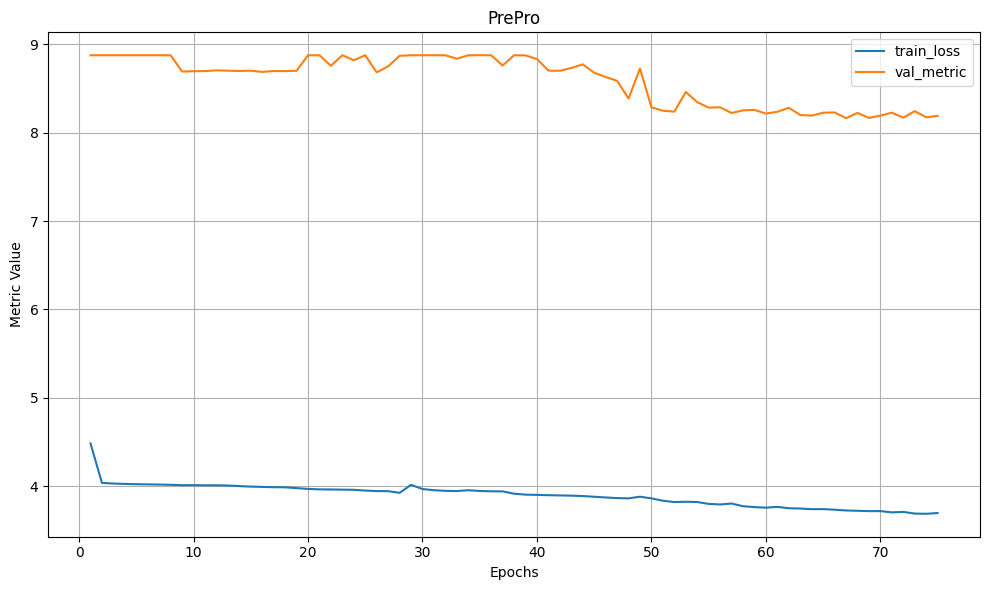

In [60]:
plot_metrics(
    preproc_metrics,
    title="PrePro",
)

Кажется, это был не самый верный подход к предобработки. Такое мы логировать не будем, чтобы потом не путаться в безрезультатных экспериментах.

## More layers model base mel

**В данном эксперименте мы сохраняем базовую предобработку данных без изменений, но модифицируем архитектуру бэйзлайн-модели: <br>
увеличиваем количество сверточных блоков до трёх и добавляем второй слой LSTM**

### Train

In [ ]:
class ModelBaseCNN(nn.Module):
    def __init__(
        self,
        input_size: Tuple[int, int],
        kernel_chanel: int,
        conv_out_size: int,
        vocab_size: int,
    ):
        super().__init__()

        self.conv_part = nn.Sequential(
            ConvBlock(
                in_channels=input_size[0],
                out_channels=kernel_chanel,
                kernel_size=5,
                padding=2,
                stride=2,
            ),
            ConvBlock(
                in_channels=kernel_chanel,
                out_channels=kernel_chanel,
                kernel_size=3,
                padding=1,
            ),
            ConvBlock(
                in_channels=kernel_chanel,
                out_channels=conv_out_size,
                kernel_size=3,
                padding=0,
            ),
        )

        self.rnn_part = nn.Sequential(
            LstmBlock(
                input_size=conv_out_size, hidden_size=128, dropout=0.4
            ),  # 128, conv_out_size,
            LstmBlock(input_size=128 * 2, hidden_size=64, dropout=0.4),
        )

        self.clf = nn.Linear(
            in_features=64 * 2,
            out_features=vocab_size,
        )

    def forward(self, x):
        x = self.conv_part(x)
        x = x.transpose(1, 2)
        x = self.rnn_part(x)
        return self.clf(x)

In [ ]:
tokens = list(full_vocab.values())
print(tokens[0])

beam_search_decoder = ctc_decoder(
    lexicon=None,
    tokens=list(full_vocab.values()),
    beam_size=3,
    nbest=1,
    blank_token="<blk>",
)

tokenizer = Tokenizer(vocab=full_vocab)

print(tokenizer.index_char)
print(tokenizer.char_index)

transform = partial(
    path_to_melspect_cached,
    audio_files_dir=AUDIO_FILES_DIR,
    cache_dir=Path("./mels_cache"),
)

<blk>
{0: '<blk>', 1: '|', 2: ' ', 3: '#', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: 'А', 15: 'Б', 16: 'В', 17: 'Г', 18: 'Д', 19: 'Е', 20: 'Ж', 21: 'З', 22: 'И', 23: 'Й', 24: 'К', 25: 'Л', 26: 'М', 27: 'Н', 28: 'О', 29: 'П', 30: 'Р', 31: 'С', 32: 'Т', 33: 'У', 34: 'Ф', 35: 'Х', 36: 'Ц', 37: 'Ч', 38: 'Ш', 39: 'Щ', 40: 'Ъ', 41: 'Ы', 42: 'Ь', 43: 'Э', 44: 'Ю', 45: 'Я'}
{'<blk>': 0, '|': 1, ' ': 2, '#': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, 'А': 14, 'Б': 15, 'В': 16, 'Г': 17, 'Д': 18, 'Е': 19, 'Ж': 20, 'З': 21, 'И': 22, 'Й': 23, 'К': 24, 'Л': 25, 'М': 26, 'Н': 27, 'О': 28, 'П': 29, 'Р': 30, 'С': 31, 'Т': 32, 'У': 33, 'Ф': 34, 'Х': 35, 'Ц': 36, 'Ч': 37, 'Ш': 38, 'Щ': 39, 'Ъ': 40, 'Ы': 41, 'Ь': 42, 'Э': 43, 'Ю': 44, 'Я': 45}


In [ ]:
train_dataset = MorseDataset(
    X_filenames=X_train,
    y_texts=y_train,
    transform=transform,
    tokenizer=tokenizer,
)

train_loader = data_loader(
    train_dataset, batch_size=128, shuffle=True, drop_last=True, num_workers=4
)

val_dataset = MorseDataset(
    X_filenames=X_val, y_texts=y_val, transform=transform, tokenizer=tokenizer
)
val_loader = data_loader(
    val_dataset, batch_size=128, shuffle=False, drop_last=True, num_workers=4
)

In [ ]:
more_cnn_model = ModelBaseCNN(
    input_size=[80, 251],
    kernel_chanel=128,
    conv_out_size=128,
    vocab_size=len(full_vocab),
)
more_cnn_model.apply(init_weights)

optimizer = torch.optim.Adam(more_cnn_model.parameters(), lr=0.01)

more_cnn_model

ModelBase(
  (conv_part): Sequential(
    (0): ConvBlock(
      (conv): Conv1d(80, 128, kernel_size=(5,), stride=(2,), padding=(2,))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
    (1): ConvBlock(
      (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
    (2): ConvBlock(
      (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
  )
  (rnn_part): Sequential(
    (0): LstmBlock(
      (lstm): LSTM(128, 128, num_layers=2, batch_first=True, bidirectional=True)
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.4, inplace=False)
    )
    (1): LstmBlock(
      (lstm): LSTM(256, 64, num_layers=2, batch_first=True, bidirectional=True)
      (norm): LayerNorm((128,), eps=1e-05, elementwise_

In [43]:
import gc

gc.collect()

5387

In [ ]:
more_cnn_model, more_cnn_metrics = train_model(
    model=more_cnn_model,
    train_loader=train_loader,
    optimizer=optimizer,
    ctc_loss=loss_ctc,
    epochs=75,
    metric=edit_distance,
    decoder=beam_search_decoder,
    tokenizer=tokenizer,
    val_loader=val_loader,
)

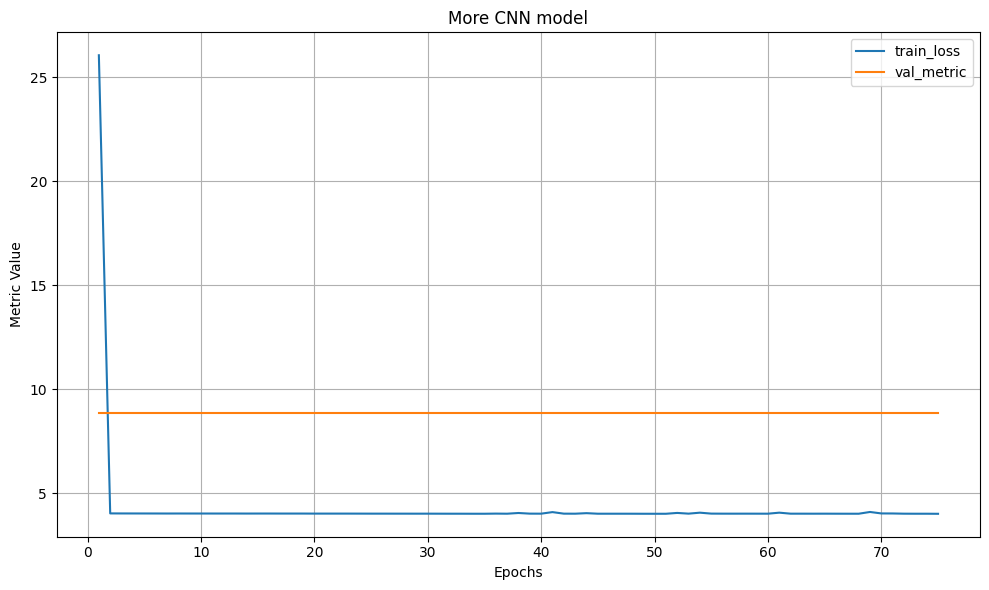

In [ ]:
plot_metrics(
    more_cnn_metrics,
    title="More CNN model",
)

Сохраним только метрики.

In [ ]:
clean_metrics = {
    key: [float(v) for v in values] for key, values in more_cnn_metrics.items()
}

with open(f"{MODELS_DIR}/more_cnn_metrics.json", "w") as fd:
    json.dump(clean_metrics, fd)
    pass


In [ ]:
# with open(f"{MODELS_DIR}/more_cnn_metrics.json", "r") as fd:
#     more_cnn_metrics = json.load(fd)

**Очередная провал. Зафиксируем метрики и основные параметры этого эксперимента, чтобы быть умнее и двигаться дальше**

### Logging Mlflow

In [ ]:
more_cnn_params = copy.deepcopy(train_params)
more_cnn_params["model"]["type"] = "ModelBaseCNN"
more_cnn_params["dataloader"]["batch_size"] = 128
more_cnn_params["dataloader"]["num_workers"] = 4
more_cnn_params["training"]["epochs"] = 75
more_cnn_params

{'model': {'type': 'ModelBaseCNN',
  'input_size': [80, 251],
  'kernel_chanel': 128,
  'conv_out_size': 128,
  'vocab_size': 46,
  'init_weights': 'init_weights()'},
 'optimizer': {'type': 'Adam', 'lr': 0.01},
 'scheduler': {'step_size': '-', 'gamma': '-'},
 'transform': {'type': 'path_to_melspect_cached()'},
 'decoder': {'type': 'ctc_decoder',
  'lexicon': None,
  'tokens_count': 46,
  'beam_size': 3,
  'nbest': 1,
  'blank_token': '<blk>'},
 'dataloader': {'batch_size': 128, 'num_workers': 4},
 'training': {'epochs': 75}}

In [210]:
more_cnn_final_metrics = {}
for key in more_cnn_metrics:
    if len(more_cnn_metrics[key]) > 0:
        more_cnn_final_metrics[key] = round(more_cnn_metrics[key][-1], 4)
more_cnn_final_metrics


{'train_loss': 4.0195, 'val_metric': 8.8739}

In [ ]:
log_to_mlflow_torch(
    "More CNN Model",
    train_params=more_cnn_params,
    metrics=more_cnn_final_metrics,
    tags={"stage": "More CNN", "preprocess": "full melspectr"},
    log_model=False,
)

MLflow Run ID: 95f8e19d4a22440483d534a70de26ec2
log_model=False — model not logged.
🏃 View run More CNN Model at: http://127.0.0.1:8080/#/experiments/1/runs/95f8e19d4a22440483d534a70de26ec2
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


{'run_id': '95f8e19d4a22440483d534a70de26ec2', 'model_info': 'no_logged_model'}

## Wiener prepro

**В данном эксперименте сохраняем архитектуру модели бэйзлайна без изменений, однако модифицируем предобработку аудио:<br> 
 исходную мел-спектрограмму пропускаем через фильтр Винера. Остальные параметры остаются без изменений.**

### Train

In [ ]:
def to_wiener_mel_cached(
    file_name: str,
    audio_files_dir: Path,
    cache_dir: Path,
    overwrite: bool = False,
) -> np.ndarray:
    cache_path = cache_dir / (file_name.replace(".opus", ".npy"))

    if cache_path.exists() and not overwrite:
        return np.load(cache_path)

    waveform, sr = torchaudio.load(audio_files_dir / file_name)

    waveform_np = waveform.squeeze(0).numpy()

    # Применяем Wiener фильтр
    wave_wiener_np = wiener(waveform_np, mysize=15)

    # Обратно в тензор
    wave_wiener = torch.tensor(wave_wiener_np, dtype=torch.float32).unsqueeze(0)

    mel = torchaudio.transforms.MelSpectrogram(
        sample_rate=sr, n_fft=1024, hop_length=256, n_mels=80
    )(wave_wiener)

    mel_db = torchaudio.transforms.AmplitudeToDB(top_db=80)(mel)
    mel_db = mel_db.squeeze(0).cpu().numpy()

    os.makedirs(cache_dir, exist_ok=True)
    np.save(cache_path, mel_db)
    return mel_db

In [ ]:
beam_search_decoder = ctc_decoder(
    lexicon=None,
    tokens=list(full_vocab.values()),
    beam_size=3,
    nbest=1,
    blank_token="<blk>",
)

In [49]:
tokenizer = Tokenizer(vocab=full_vocab)

print(tokenizer.index_char)
print(tokenizer.char_index)

transform = partial(
    to_wiener_mel_cached,
    audio_files_dir=AUDIO_FILES_DIR,
    cache_dir=Path("./wiener_mels_cache"),
)


{0: '<blk>', 1: '|', 2: ' ', 3: '#', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: 'А', 15: 'Б', 16: 'В', 17: 'Г', 18: 'Д', 19: 'Е', 20: 'Ж', 21: 'З', 22: 'И', 23: 'Й', 24: 'К', 25: 'Л', 26: 'М', 27: 'Н', 28: 'О', 29: 'П', 30: 'Р', 31: 'С', 32: 'Т', 33: 'У', 34: 'Ф', 35: 'Х', 36: 'Ц', 37: 'Ч', 38: 'Ш', 39: 'Щ', 40: 'Ъ', 41: 'Ы', 42: 'Ь', 43: 'Э', 44: 'Ю', 45: 'Я'}
{'<blk>': 0, '|': 1, ' ': 2, '#': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, 'А': 14, 'Б': 15, 'В': 16, 'Г': 17, 'Д': 18, 'Е': 19, 'Ж': 20, 'З': 21, 'И': 22, 'Й': 23, 'К': 24, 'Л': 25, 'М': 26, 'Н': 27, 'О': 28, 'П': 29, 'Р': 30, 'С': 31, 'Т': 32, 'У': 33, 'Ф': 34, 'Х': 35, 'Ц': 36, 'Ч': 37, 'Ш': 38, 'Щ': 39, 'Ъ': 40, 'Ы': 41, 'Ь': 42, 'Э': 43, 'Ю': 44, 'Я': 45}


In [ ]:
train_dataset = MorseDataset(
    X_filenames=X_train,
    y_texts=y_train,
    transform=transform,
    tokenizer=tokenizer,
)

train_loader = data_loader(
    train_dataset, batch_size=32, shuffle=True, drop_last=True, num_workers=0
)

val_dataset = MorseDataset(
    X_filenames=X_val, y_texts=y_val, transform=transform, tokenizer=tokenizer
)
val_loader = data_loader(
    val_dataset, batch_size=32, shuffle=False, drop_last=True, num_workers=0
)

In [54]:
import gc

gc.collect()

1150

In [ ]:
%%time 
wiener_model, wiener_metrics = train_model(
    model=wiener_model,
    train_loader=train_loader,
    optimizer=optimizer,
    ctc_loss=loss_ctc,
    epochs=50,
    metric=edit_distance,
    decoder=beam_search_decoder,
    tokenizer=tokenizer,
    val_loader=val_loader,
)

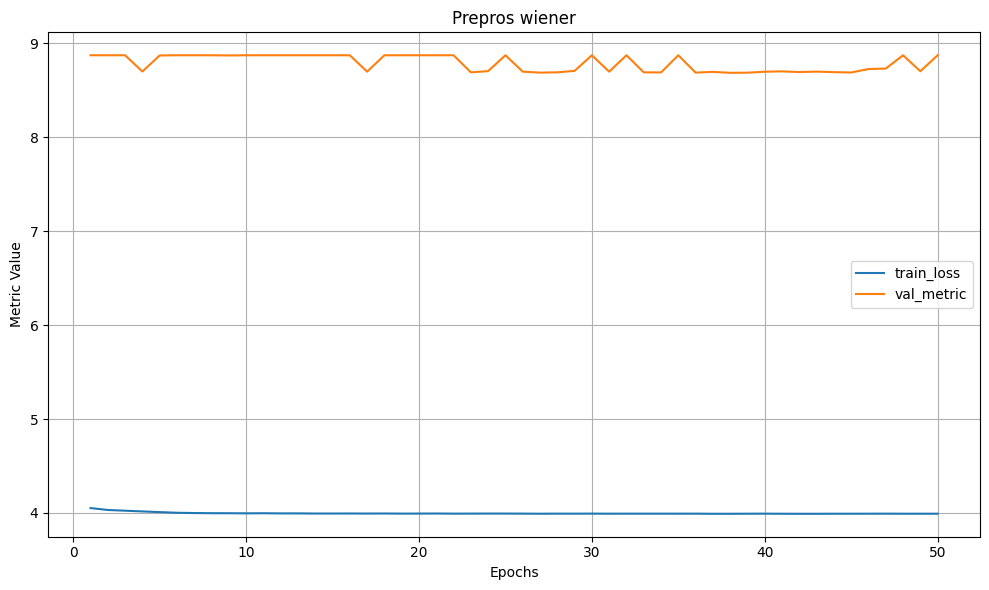

In [58]:
plot_metrics(
    wiener_metrics,
    title="Prepros wiener",
)

**Кажется, предобработка пока делает только хуже, бэйзлайн все еще недосягаемо хорош**

Оставим это без логирования, продолжим искать более удачный подход к предобработке.

## WideMel - narrow window

**В данном эксперименте сохраняем архитектуру модели бэйзлайна без изменений, однако модифицируем предобработку аудио:<br>
исходную мел-спектрограмму формируем с параметрами окна 512 и шага 128 — это должно позволить получить более детальное представление о сигнале и «увидеть» его структуру четче**

### Train

In [ ]:
def path_to_widemel_cached(
    file_name: str,
    audio_files_dir: Path,
    cache_dir: Path,
    overwrite: bool = False,
) -> np.ndarray:
    cache_path = cache_dir / (file_name.replace(".opus", ".npy"))

    if cache_path.exists() and not overwrite:
        return np.load(cache_path)

    waveform, sr = torchaudio.load(audio_files_dir / file_name)

    mel = torchaudio.transforms.MelSpectrogram(
        sample_rate=sr, n_fft=512, hop_length=128, n_mels=80
    )(waveform)
    mel_db = torchaudio.transforms.AmplitudeToDB(top_db=80)(mel)
    mel_db = mel_db.squeeze(0).cpu().numpy()

    os.makedirs(cache_dir, exist_ok=True)
    np.save(cache_path, mel_db)
    return mel_db

In [ ]:
beam_search_decoder = ctc_decoder(
    lexicon=None,
    tokens=list(full_vocab.values()),
    beam_size=3,
    nbest=1,
    blank_token="<blk>",
)

In [62]:
tokenizer = Tokenizer(vocab=full_vocab)

print(tokenizer.index_char)
print(tokenizer.char_index)

transform = partial(
    path_to_widemel_cached,
    audio_files_dir=AUDIO_FILES_DIR,
    cache_dir=Path("./widemels_cache"),
)


{0: '<blk>', 1: '|', 2: ' ', 3: '#', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: 'А', 15: 'Б', 16: 'В', 17: 'Г', 18: 'Д', 19: 'Е', 20: 'Ж', 21: 'З', 22: 'И', 23: 'Й', 24: 'К', 25: 'Л', 26: 'М', 27: 'Н', 28: 'О', 29: 'П', 30: 'Р', 31: 'С', 32: 'Т', 33: 'У', 34: 'Ф', 35: 'Х', 36: 'Ц', 37: 'Ч', 38: 'Ш', 39: 'Щ', 40: 'Ъ', 41: 'Ы', 42: 'Ь', 43: 'Э', 44: 'Ю', 45: 'Я'}
{'<blk>': 0, '|': 1, ' ': 2, '#': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, 'А': 14, 'Б': 15, 'В': 16, 'Г': 17, 'Д': 18, 'Е': 19, 'Ж': 20, 'З': 21, 'И': 22, 'Й': 23, 'К': 24, 'Л': 25, 'М': 26, 'Н': 27, 'О': 28, 'П': 29, 'Р': 30, 'С': 31, 'Т': 32, 'У': 33, 'Ф': 34, 'Х': 35, 'Ц': 36, 'Ч': 37, 'Ш': 38, 'Щ': 39, 'Ъ': 40, 'Ы': 41, 'Ь': 42, 'Э': 43, 'Ю': 44, 'Я': 45}


In [ ]:
train_dataset = MorseDataset(
    X_filenames=X_train,
    y_texts=y_train,
    transform=transform,
    tokenizer=tokenizer,
)

train_loader = data_loader(
    train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=0
)

val_dataset = MorseDataset(
    X_filenames=X_val, y_texts=y_val, transform=transform, tokenizer=tokenizer
)
val_loader = data_loader(
    val_dataset, batch_size=64, shuffle=False, drop_last=True, num_workers=0
)

In [67]:
widemel_model = ModelBase(
    input_size=[80, 501],
    kernel_chanel=128,
    conv_out_size=128,
    vocab_size=len(full_vocab),
)
widemel_model.apply(init_weights)

optimizer = torch.optim.Adam(widemel_model.parameters(), lr=0.01)

widemel_model

ModelBase(
  (conv_part): Sequential(
    (0): ConvBlock(
      (conv): Conv1d(80, 128, kernel_size=(5,), stride=(2,), padding=(2,))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
  )
  (rnn_part): Sequential(
    (0): LstmBlock(
      (lstm): LSTM(128, 64, num_layers=2, batch_first=True, bidirectional=True)
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.4, inplace=False)
    )
  )
  (clf): Linear(in_features=128, out_features=46, bias=True)
)

In [68]:
import gc

gc.collect()

4791

In [ ]:
%%time 
widemel_model, widemel_metrics = train_model(
    model=widemel_model,
    train_loader=train_loader,
    optimizer=optimizer,
    ctc_loss=loss_ctc,
    epochs=50,
    metric=edit_distance,
    decoder=beam_search_decoder,
    tokenizer=tokenizer,
    val_loader=val_loader,
)

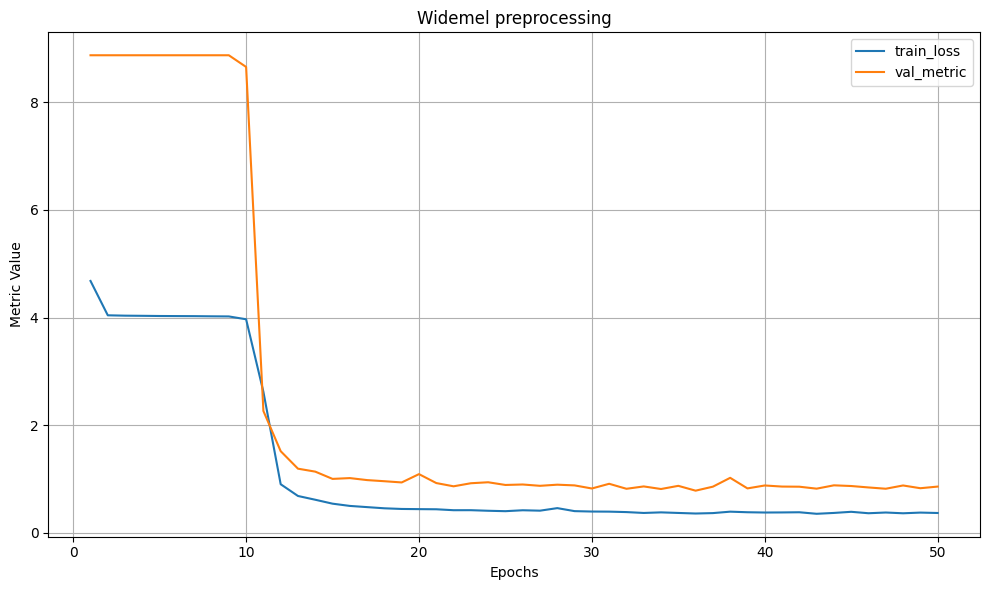

In [247]:
plot_metrics(
    widemel_metrics,
    "Widemel preprocessing",
)

Save

In [ ]:
widemel_model_path = MODELS_DIR / "widemel_model.pt"

save_model_metrics(
    widemel_model, widemel_metrics, widemel_model_path, "widemel_metrics.json"
)

### Test

In [ ]:
sub_widemel = model_predict(
    model=widemel_model,
    test_paths=data["test"]["id"],
    tokenizer=tokenizer,
    decoder=beam_search_decoder,
    batch_size=32,
)

Predicting: 100%|██████████| 157/157 [01:22<00:00,  1.91it/s, Predictions=5000]


In [73]:
sub_widemel = sub_widemel.set_index("id")
print(sub_widemel)
sub_widemel.to_csv(os.path.join(DATA_DIR.joinpath("submits/widemel_submit.csv")))

               message
id                    
30001.opus   ЯЮ6ЛИТЖБШ
30002.opus    КЩ В9Ю 9
30003.opus     Ы65Ф61Я
30004.opus  ЖЖНЖ9РЫНЦ3
30005.opus     ЕЙФ4ЮЧЬ
...                ...
34996.opus            
34997.opus            
34998.opus            
34999.opus            
35000.opus      Щ8ЛЕЕС

[5000 rows x 1 columns]


**Кажется успешный подход найден. Более четкий сигнал дал ощутимое улучшение**

### Logging Mlflow

In [249]:
widemel_params = copy.deepcopy(train_params)
widemel_params["model"]["input_size"] = [80, 501]
widemel_params["transform"]["type"] = "path_to_widemel_cached()"
widemel_params

{'model': {'type': 'ModelBase',
  'input_size': [80, 501],
  'kernel_chanel': 128,
  'conv_out_size': 128,
  'vocab_size': 46,
  'init_weights': 'init_weights()'},
 'optimizer': {'type': 'Adam', 'lr': 0.01},
 'scheduler': {'step_size': '-', 'gamma': '-'},
 'transform': {'type': 'path_to_widemel_cached()'},
 'decoder': {'type': 'ctc_decoder',
  'lexicon': None,
  'tokens_count': 46,
  'beam_size': 3,
  'nbest': 1,
  'blank_token': '<blk>'},
 'dataloader': {'batch_size': 64, 'num_workers': 0},
 'training': {'epochs': 50}}

In [251]:
widemel_final_metrics = {}
for key in widemel_metrics:
    if len(widemel_metrics[key]) > 0:
        widemel_final_metrics[key] = round(widemel_metrics[key][-1], 4)
widemel_final_metrics


{'train_loss': 0.3687, 'val_metric': 0.8594}

In [252]:
log_to_mlflow_torch(
    "Wide mel",
    train_params=widemel_params,
    metrics=widemel_final_metrics,
    metadata={"architecture": "1 CNN, 1 RNN, 1 FC"},
    registry_model_name="Widemel_base",
    fitted_model=widemel_model,
    tags={"stage": "widemel", "preprocess": "full wide melspectr"},
)

MLflow Run ID: b7a9f0aae79f4d63a53e5bffa3f6a82e
Starting model logging to MLflow.


2025/04/21 08:29:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Widemel_base'.
2025/04/21 08:29:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: Widemel_base, version 1


🏃 View run Wide mel at: http://127.0.0.1:8080/#/experiments/1/runs/b7a9f0aae79f4d63a53e5bffa3f6a82e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


Created version '1' of model 'Widemel_base'.


{'model_uri': 'runs:/b7a9f0aae79f4d63a53e5bffa3f6a82e/models',
 'run_id': 'b7a9f0aae79f4d63a53e5bffa3f6a82e',
 'model_name': 'Widemel_base',
 'metadata': {'architecture': '1 CNN, 1 RNN, 1 FC'}}

## More cnn

**В данном эксперименте сохраняем предобработку с прошлого шага, но уменьшаем количество mel-бинов до 64 <br> 
— это позволит немного растянуть сигнал по временной оси. Архитектуру модели расширяем до трёх сверточных слоев <br> 
с обновлёнными параметрами свёрток, остальные компоненты остаются без изменений**

### Train

In [33]:
def path_to_mel_cnn_cached(
    file_name: str,
    audio_files_dir: Path,
    cache_dir: Path,
    overwrite: bool = False,
) -> np.ndarray:
    cache_path = cache_dir / (file_name.replace(".opus", ".npy"))

    if cache_path.exists() and not overwrite:
        return np.load(cache_path)

    waveform, sr = torchaudio.load(audio_files_dir / file_name)

    mel = torchaudio.transforms.MelSpectrogram(
        sample_rate=sr, n_fft=512, hop_length=128, n_mels=64
    )(waveform)
    mel_db = torchaudio.transforms.AmplitudeToDB(top_db=64)(mel)
    mel_db = mel_db.squeeze(0).cpu().numpy()

    os.makedirs(cache_dir, exist_ok=True)
    np.save(cache_path, mel_db)
    return mel_db

In [ ]:
class ModelCNN(nn.Module):
    def __init__(
        self,
        input_size: Tuple[int, int],
        kernel_chanel: int,
        conv_out_size: int,
        vocab_size: int,
    ):
        super().__init__()

        self.conv_part = nn.Sequential(
            ConvBlock(
                in_channels=input_size[0],
                out_channels=kernel_chanel,
                kernel_size=5,
                padding=2,
                stride=2,
            ),
            ConvBlock(
                in_channels=kernel_chanel,
                out_channels=conv_out_size,
                kernel_size=4,
                padding=0,
                stride=2,
            ),
            ConvBlock(
                in_channels=conv_out_size,
                out_channels=conv_out_size,
                kernel_size=3,
                padding=0,
            ),
        )

        self.rnn_part = nn.Sequential(
            LstmBlock(input_size=conv_out_size, hidden_size=64, dropout=0.4),
        )

        self.clf = nn.Linear(
            in_features=64 * 2,
            out_features=vocab_size,
        )

    def forward(self, x):
        x = self.conv_part(x)
        x = x.transpose(1, 2)
        x = self.rnn_part(x)
        return self.clf(x)

In [ ]:
beam_search_decoder = ctc_decoder(
    lexicon=None,
    tokens=list(full_vocab.values()),
    beam_size=3,
    nbest=1,
    blank_token="<blk>",
)

In [34]:
tokenizer = Tokenizer(vocab=full_vocab)

print(tokenizer.index_char)
print(tokenizer.char_index)

transform = partial(
    path_to_mel_cnn_cached,
    audio_files_dir=AUDIO_FILES_DIR,
    cache_dir=Path("./mels_cnn_cache"),
)


{0: '<blk>', 1: '|', 2: ' ', 3: '#', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: 'А', 15: 'Б', 16: 'В', 17: 'Г', 18: 'Д', 19: 'Е', 20: 'Ж', 21: 'З', 22: 'И', 23: 'Й', 24: 'К', 25: 'Л', 26: 'М', 27: 'Н', 28: 'О', 29: 'П', 30: 'Р', 31: 'С', 32: 'Т', 33: 'У', 34: 'Ф', 35: 'Х', 36: 'Ц', 37: 'Ч', 38: 'Ш', 39: 'Щ', 40: 'Ъ', 41: 'Ы', 42: 'Ь', 43: 'Э', 44: 'Ю', 45: 'Я'}
{'<blk>': 0, '|': 1, ' ': 2, '#': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, 'А': 14, 'Б': 15, 'В': 16, 'Г': 17, 'Д': 18, 'Е': 19, 'Ж': 20, 'З': 21, 'И': 22, 'Й': 23, 'К': 24, 'Л': 25, 'М': 26, 'Н': 27, 'О': 28, 'П': 29, 'Р': 30, 'С': 31, 'Т': 32, 'У': 33, 'Ф': 34, 'Х': 35, 'Ц': 36, 'Ч': 37, 'Ш': 38, 'Щ': 39, 'Ъ': 40, 'Ы': 41, 'Ь': 42, 'Э': 43, 'Ю': 44, 'Я': 45}


In [ ]:
train_dataset = MorseDataset(
    X_filenames=X_train,
    y_texts=y_train,
    transform=transform,
    tokenizer=tokenizer,
)

train_loader = data_loader(
    train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=0
)

val_dataset = MorseDataset(
    X_filenames=X_val, y_texts=y_val, transform=transform, tokenizer=tokenizer
)
val_loader = data_loader(
    val_dataset, batch_size=64, shuffle=False, drop_last=True, num_workers=0
)

In [38]:
cnn_model = ModelCNN(
    input_size=[64, 501],
    kernel_chanel=80,
    conv_out_size=64,
    vocab_size=len(full_vocab),
)
cnn_model.apply(init_weights)

optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.01)

cnn_model

ModelCNN(
  (conv_part): Sequential(
    (0): ConvBlock(
      (conv): Conv1d(64, 80, kernel_size=(5,), stride=(2,), padding=(2,))
      (norm): LayerNorm((80,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
    (1): ConvBlock(
      (conv): Conv1d(80, 64, kernel_size=(4,), stride=(2,))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
    (2): ConvBlock(
      (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
  )
  (rnn_part): Sequential(
    (0): LstmBlock(
      (lstm): LSTM(64, 64, num_layers=2, batch_first=True, bidirectional=True)
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.4, inplace=False)
    )
  )
  (clf): Linear(in_features=128, out_features=46, bias=True)
)

In [262]:
import gc

gc.collect()

14971

In [ ]:
%%time 
cnn_model, cnn_metrics = train_model(
    model=cnn_model,
    train_loader=train_loader,
    optimizer=optimizer,
    ctc_loss=loss_ctc,
    epochs=50,
    metric=edit_distance,
    decoder=beam_search_decoder,
    tokenizer=tokenizer,
    val_loader=val_loader,
)

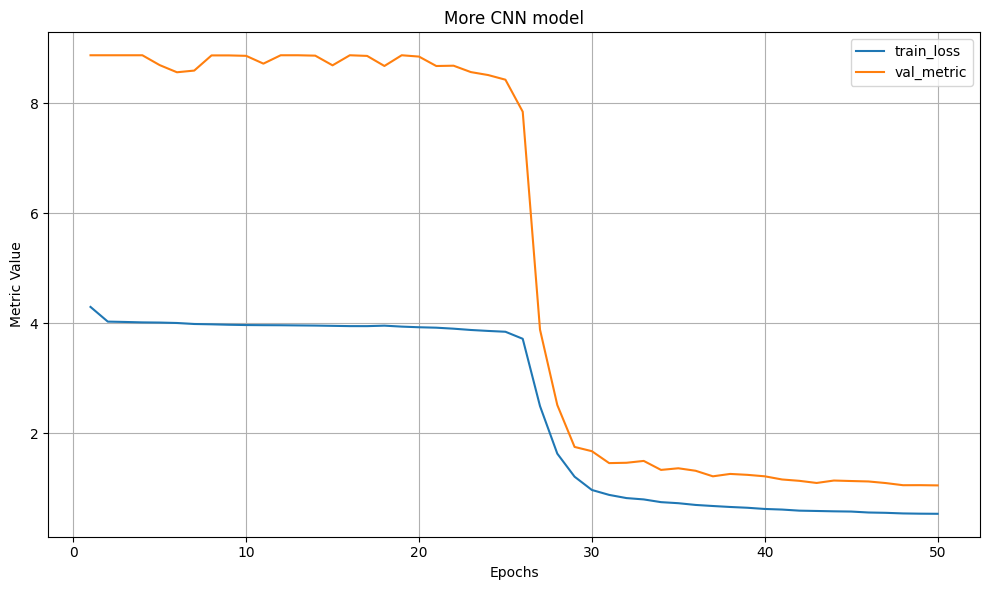

In [40]:
plot_metrics(
    cnn_metrics,
    "More CNN model",
)

Save

In [ ]:
cnn_model_path = MODELS_DIR / "cnn_model.pt"


save_model_metrics(cnn_model, cnn_metrics, cnn_model_path, "cnn_metrics.json")

**Данный эксперимент дошел примерно до тех же метрик, но сходился чуть дольше,- все еще не идеальный рецепт**

### Logging Mlflow

In [326]:
cnn_params = copy.deepcopy(train_params)
cnn_params["model"]["type"] = "ModelCNN"
cnn_params["model"]["input_size"] = [64, 501]
cnn_params["model"]["kernel_chanel"] = 80
cnn_params["model"]["conv_out_size"] = 64
cnn_params["transform"]["type"] = "path_to_mel_cnn_cached()"
cnn_params

{'model': {'type': 'ModelCNN',
  'input_size': [64, 501],
  'kernel_chanel': 80,
  'conv_out_size': 64,
  'vocab_size': 46,
  'init_weights': 'init_weights()'},
 'optimizer': {'type': 'Adam', 'lr': 0.01},
 'scheduler': {'step_size': '-', 'gamma': '-'},
 'transform': {'type': 'path_to_mel_cnn_cached()'},
 'decoder': {'type': 'ctc_decoder',
  'lexicon': None,
  'tokens_count': 46,
  'beam_size': 3,
  'nbest': 1,
  'blank_token': '<blk>'},
 'dataloader': {'batch_size': 64, 'num_workers': 0},
 'training': {'epochs': 50}}

In [327]:
cnn_final_metrics = {}
for key in cnn_metrics:
    if len(cnn_metrics[key]) > 0:
        cnn_final_metrics[key] = round(cnn_metrics[key][-1], 4)
cnn_final_metrics


{'train_loss': np.float64(0.5399), 'val_metric': np.float64(1.056)}

In [328]:
log_to_mlflow_torch(
    "CNN mel64",
    train_params=cnn_params,
    metrics=cnn_final_metrics,
    metadata={"architecture": "3 CNN, 1 RNN, 1 FC"},
    registry_model_name="CNN model",
    fitted_model=cnn_model,
    tags={"stage": "more CNN", "preprocess": "full wide melspectr64"},
)

MLflow Run ID: db26bf769fb14a29964f49b7a984c823
Starting model logging to MLflow.


2025/04/21 14:45:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'CNN model'.
2025/04/21 14:45:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: CNN model, version 1


🏃 View run CNN mel64 at: http://127.0.0.1:8080/#/experiments/1/runs/db26bf769fb14a29964f49b7a984c823
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


Created version '1' of model 'CNN model'.


{'model_uri': 'runs:/db26bf769fb14a29964f49b7a984c823/models',
 'run_id': 'db26bf769fb14a29964f49b7a984c823',
 'model_name': 'CNN model',
 'metadata': {'architecture': '3 CNN, 1 RNN, 1 FC'}}


## Boost, prune & more cnn


**В данном эксперименте пробуем сделать предобработку более тщательной: используем мел-спектрограммы с окном 512, шагом 128 и 64 мел-бинами, <br> 
после чего возводим спектрограмму в степень, нормализуем и оставляем диапазон в 20 мел-бинов вокруг самого мощного сигнала. <br> 
Архитектуру модели сохраняем с тремя сверточными блоками, но немного уменьшаем их параметры — входные данные теперь меньше по размеру.**

### Train

In [80]:
def path_to_blackmel_cached(
    file_name: str,
    audio_files_dir: Path,
    cache_dir: Path,
    overwrite: bool = False,
) -> np.ndarray:
    cache_path = cache_dir / (file_name.replace(".opus", ".npy"))

    if cache_path.exists() and not overwrite:
        return np.load(cache_path)

    waveform, sr = torchaudio.load(audio_files_dir / file_name)

    mel = torchaudio.transforms.MelSpectrogram(
        sample_rate=sr, n_fft=512, hop_length=128, n_mels=64
    )(waveform)
    boost_mel = mel**5
    boost_mel = boost_mel / boost_mel.max()
    mel_db = torchaudio.transforms.AmplitudeToDB(top_db=64)(boost_mel)
    mel_db = mel_db.squeeze(0).cpu().numpy()

    peak = np.argmax(mel_db.mean(axis=1))
    start = max(peak - 10, 0)
    end = min(peak + 10, mel_db.shape[0])
    fresh_mel = mel_db[start:end]

    os.makedirs(cache_dir, exist_ok=True)
    np.save(cache_path, fresh_mel)
    return fresh_mel

In [ ]:
class ModelCNN_small(nn.Module):
    def __init__(
        self,
        input_size: Tuple[int, int],
        kernel_chanel: int,
        conv_out_size: int,
        vocab_size: int,
    ):
        super().__init__()

        self.conv_part = nn.Sequential(
            ConvBlock(
                in_channels=input_size[0],
                out_channels=kernel_chanel,
                kernel_size=5,
                padding=2,
                stride=2,
            ),
            ConvBlock(
                in_channels=kernel_chanel,
                out_channels=conv_out_size,
                kernel_size=4,
                padding=0,
                stride=2,
            ),
            ConvBlock(
                in_channels=conv_out_size,
                out_channels=conv_out_size,
                kernel_size=3,
                padding=0,
            ),
        )

        self.rnn_part = nn.Sequential(
            LstmBlock(input_size=conv_out_size, hidden_size=64, dropout=0.4),
        )

        self.clf = nn.Linear(
            in_features=64 * 2,
            out_features=vocab_size,
        )

    def forward(self, x):
        x = self.conv_part(x)
        x = x.transpose(1, 2)
        x = self.rnn_part(x)
        return self.clf(x)

In [ ]:
beam_search_decoder = ctc_decoder(
    lexicon=None,
    tokens=list(full_vocab.values()),
    beam_size=3,
    nbest=1,
    blank_token="<blk>",
)

In [133]:
tokenizer = Tokenizer(vocab=full_vocab)

print(tokenizer.index_char)
print(tokenizer.char_index)

transform = partial(
    path_to_blackmel_cached,
    audio_files_dir=AUDIO_FILES_DIR,
    cache_dir=Path("./blackmels_cnn_cache"),
)


{0: '<blk>', 1: '|', 2: ' ', 3: '#', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: 'А', 15: 'Б', 16: 'В', 17: 'Г', 18: 'Д', 19: 'Е', 20: 'Ж', 21: 'З', 22: 'И', 23: 'Й', 24: 'К', 25: 'Л', 26: 'М', 27: 'Н', 28: 'О', 29: 'П', 30: 'Р', 31: 'С', 32: 'Т', 33: 'У', 34: 'Ф', 35: 'Х', 36: 'Ц', 37: 'Ч', 38: 'Ш', 39: 'Щ', 40: 'Ъ', 41: 'Ы', 42: 'Ь', 43: 'Э', 44: 'Ю', 45: 'Я'}
{'<blk>': 0, '|': 1, ' ': 2, '#': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, 'А': 14, 'Б': 15, 'В': 16, 'Г': 17, 'Д': 18, 'Е': 19, 'Ж': 20, 'З': 21, 'И': 22, 'Й': 23, 'К': 24, 'Л': 25, 'М': 26, 'Н': 27, 'О': 28, 'П': 29, 'Р': 30, 'С': 31, 'Т': 32, 'У': 33, 'Ф': 34, 'Х': 35, 'Ц': 36, 'Ч': 37, 'Ш': 38, 'Щ': 39, 'Ъ': 40, 'Ы': 41, 'Ь': 42, 'Э': 43, 'Ю': 44, 'Я': 45}


In [ ]:
train_dataset = MorseDataset(
    X_filenames=X_train,
    y_texts=y_train,
    transform=transform,
    tokenizer=tokenizer,
)

train_loader = data_loader(
    train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=0
)

val_dataset = MorseDataset(
    X_filenames=X_val, y_texts=y_val, transform=transform, tokenizer=tokenizer
)
val_loader = data_loader(
    val_dataset, batch_size=64, shuffle=False, drop_last=True, num_workers=0
)

In [ ]:
cnn_blackmel_model = ModelCNN_small(
    input_size=[20, 501],
    kernel_chanel=32,
    conv_out_size=64,
    vocab_size=len(full_vocab),
)
torch.manual_seed(SEED)
cnn_blackmel_model.apply(init_weights)

optimizer = torch.optim.Adam(cnn_blackmel_model.parameters(), lr=0.005)

step_lr = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

cnn_blackmel_model

ModelCNN(
  (conv_part): Sequential(
    (0): ConvBlock(
      (conv): Conv1d(20, 32, kernel_size=(5,), stride=(2,), padding=(2,))
      (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
    (1): ConvBlock(
      (conv): Conv1d(32, 64, kernel_size=(4,), stride=(2,))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
    (2): ConvBlock(
      (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
  )
  (rnn_part): Sequential(
    (0): LstmBlock(
      (lstm): LSTM(64, 64, num_layers=2, batch_first=True, bidirectional=True)
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.4, inplace=False)
    )
  )
  (clf): Linear(in_features=128, out_features=46, bias=True)
)

In [227]:
import gc

gc.collect()

4408

In [ ]:
%%time 
cnn_blackmel_model, cnn_blackmel_metrics = train_model(
    model=cnn_blackmel_model,
    train_loader=train_loader,
    optimizer=optimizer,
    ctc_loss=loss_ctc,
    epochs=35,
    metric=edit_distance,
    decoder=beam_search_decoder,
    tokenizer=tokenizer,
    val_loader=val_loader,
    scheduler=step_lr,
)

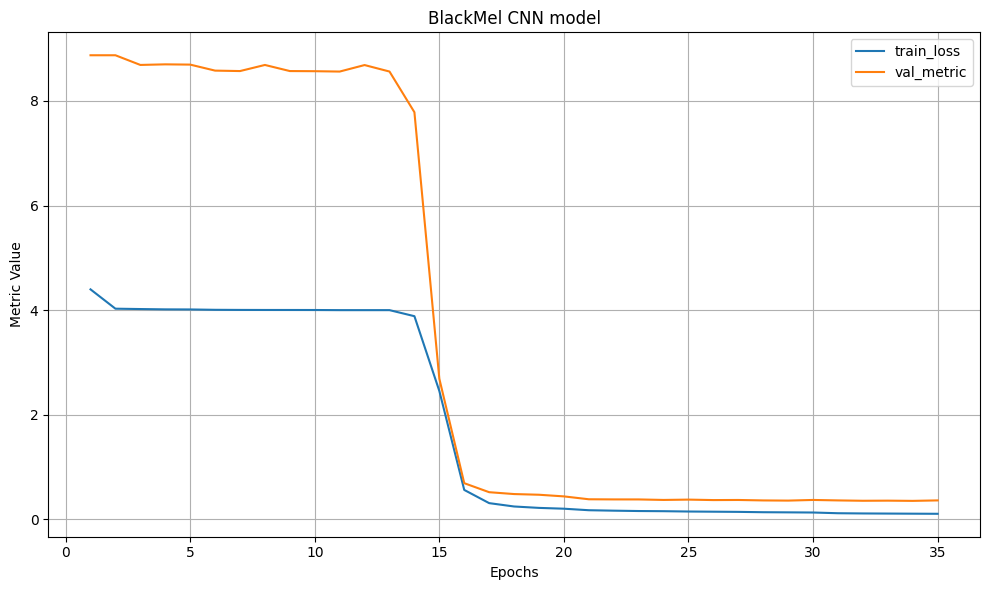

In [143]:
plot_metrics(
    cnn_blackmel_metrics,
    "BlackMel CNN model",
)

Save

In [ ]:
cnn_blackmel_path = MODELS_DIR / "cnn_blackmel_model.pt"

save_model_metrics(
    cnn_blackmel_model,
    cnn_blackmel_metrics,
    cnn_blackmel_path,
    "cnn_blackmel_metrics.json",
)

**Модифицированная предобработка и обновлённая архитектура модели продемонстрировали значительное улучшение: модель достигла уровня Character Error Rate (CER) 0.36 на валидационной выборке и на тестовой улучшила результат до 0.52. Это лучший результат на текущем этапе экспериментов.**

### Test

In [ ]:
sub_cnn_blackmel = model_predict(
    model=cnn_blackmel_model,
    test_paths=data["test"]["id"],
    tokenizer=tokenizer,
    decoder=beam_search_decoder,
    batch_size=32,
)

Predicting: 100%|██████████| 157/157 [01:11<00:00,  2.19it/s, Predictions=5000]


In [ ]:
sub_cnn_blackmel = sub_cnn_blackmel.set_index("id")
print(sub_cnn_blackmel)
sub_cnn_blackmel.to_csv(
    os.path.join(DATA_DIR.joinpath("submits/cnn_blackmel_submit.csv"))
)

In [148]:
sub_cnn_blackmel

,message
id,
30001.opus,ЯЮ6ЛИТЖБШ
30002.opus,КЩ В9Ю 9
30003.opus,Ы65Ф61Я
30004.opus,ЖЖНЖ9РЫНЦ3
30005.opus,ЕЯФ4ЮЧЬ
...,...
34996.opus,ОРСКС ИЛ ДАСДП ЬСОЕМУАТИ ЕНБАЛ КНРТЕАЛШ ВДМУНЕ...
34997.opus,СЧТИ СЕЬКСЭП ЮН ДНИМ4НОМЕТЫПАЛ ЖТЫАСР
34998.opus,ТОЫМ ДЛ ЬСЧТЫНТЕТ ДТКАГЕПОЦ В4СБ НН


### Logging Mlflow

In [329]:
train_params

{'model': {'type': 'ModelBase',
  'input_size': [80, 251],
  'kernel_chanel': 128,
  'conv_out_size': 128,
  'vocab_size': 46,
  'init_weights': 'init_weights()'},
 'optimizer': {'type': 'Adam', 'lr': 0.01},
 'scheduler': {'step_size': '-', 'gamma': '-'},
 'transform': {'type': 'path_to_melspect_cached()'},
 'decoder': {'type': 'ctc_decoder',
  'lexicon': None,
  'tokens_count': 46,
  'beam_size': 3,
  'nbest': 1,
  'blank_token': '<blk>'},
 'dataloader': {'batch_size': 64, 'num_workers': 0},
 'training': {'epochs': 50}}

In [330]:
cnn_blackmel_params = copy.deepcopy(train_params)
cnn_blackmel_params["model"]["type"] = "ModelCNN_small"
cnn_blackmel_params["model"]["input_size"] = [20, 501]
cnn_blackmel_params["model"]["kernel_chanel"] = 32
cnn_blackmel_params["model"]["conv_out_size"] = 64
cnn_blackmel_params["transform"]["type"] = "path_to_blackmel_cached()"
cnn_blackmel_params["training"]["epochs"] = 35
cnn_blackmel_params

{'model': {'type': 'ModelCNN_small',
  'input_size': [20, 501],
  'kernel_chanel': 32,
  'conv_out_size': 64,
  'vocab_size': 46,
  'init_weights': 'init_weights()'},
 'optimizer': {'type': 'Adam', 'lr': 0.01},
 'scheduler': {'step_size': '-', 'gamma': '-'},
 'transform': {'type': 'path_to_blackmel_cached()'},
 'decoder': {'type': 'ctc_decoder',
  'lexicon': None,
  'tokens_count': 46,
  'beam_size': 3,
  'nbest': 1,
  'blank_token': '<blk>'},
 'dataloader': {'batch_size': 64, 'num_workers': 0},
 'training': {'epochs': 35}}

In [331]:
cnn_blackmel_final_metrics = {}
for key in cnn_blackmel_metrics:
    if len(cnn_blackmel_metrics[key]) > 0:
        cnn_blackmel_final_metrics[key] = round(cnn_blackmel_metrics[key][-1], 4)
cnn_blackmel_final_metrics


{'train_loss': np.float64(0.1039), 'val_metric': np.float64(0.36)}

In [333]:
log_to_mlflow_torch(
    "CNN small blackmel20",
    train_params=cnn_blackmel_params,
    metrics=cnn_blackmel_final_metrics,
    metadata={"architecture": "3 CNN, 1 RNN, 1 FC"},
    registry_model_name="CNN_small blackmel20",
    fitted_model=cnn_blackmel_model,
    tags={"stage": "small CNN", "preprocess": "black melspectr20"},
)

MLflow Run ID: b2a2b106c9594ba38f1f57dbcaa2d840
Starting model logging to MLflow.


2025/04/21 14:59:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'CNN_small blackmel20'.
2025/04/21 14:59:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: CNN_small blackmel20, version 1


🏃 View run CNN small blackmel20 at: http://127.0.0.1:8080/#/experiments/1/runs/b2a2b106c9594ba38f1f57dbcaa2d840
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


Created version '1' of model 'CNN_small blackmel20'.


{'model_uri': 'runs:/b2a2b106c9594ba38f1f57dbcaa2d840/models',
 'run_id': 'b2a2b106c9594ba38f1f57dbcaa2d840',
 'model_name': 'CNN_small blackmel20',
 'metadata': {'architecture': '3 CNN, 1 RNN, 1 FC'}}

## Tune params

**В данном разделе попробуем улучшить предыдущий подход за счет подбора гиперпараметров процесса обучения и архитектуры модели с помощью optuna**

Пересоздадим класс модели для подбора идеальной архитектуры и подготовим функции для запуска подбора параметров.

In [ ]:
class ModelTuneCNN(nn.Module):
    def __init__(
        self,
        input_size: Tuple[int, int],
        kernel_chanel: int,
        conv_out_size: int,
        kernel_size1: int,
        kernel_size2: int,
        kernel_size3: int,
        stride2: int,
        lstm_hidden_size: int,
        vocab_size: int,
    ):
        super().__init__()

        self.conv_part = nn.Sequential(
            ConvBlock(
                in_channels=input_size[0],
                out_channels=kernel_chanel,
                kernel_size=kernel_size1,
                padding=2,
                stride=2,
            ),
            ConvBlock(
                in_channels=kernel_chanel,
                out_channels=conv_out_size,
                kernel_size=kernel_size2,
                padding=0,
                stride=stride2,
            ),
            ConvBlock(
                in_channels=conv_out_size,
                out_channels=conv_out_size,
                kernel_size=kernel_size3,
                padding=0,
            ),
        )

        self.rnn_part = nn.Sequential(
            LstmBlock(
                input_size=conv_out_size, hidden_size=lstm_hidden_size, dropout=0.4
            )
        )

        self.clf = nn.Linear(
            in_features=lstm_hidden_size * 2,
            out_features=vocab_size,
        )

    def forward(self, x):
        x = self.conv_part(x)
        x = x.transpose(1, 2)
        x = self.rnn_part(x)
        return self.clf(x)

In [78]:
def get_params(trial):
    return {
        "model": {
            "kernel_chanel": trial.suggest_categorical(
                "model.kernel_chanel", [16, 32, 64]
            ),
            "conv_out_size": trial.suggest_categorical(
                "model.conv_out_size", [32, 64, 128]
            ),
            "lstm_hidden_size": trial.suggest_categorical(
                "model.lstm_hidden_size", [32, 64, 128]
            ),
            "kernel_size1": trial.suggest_int("model.kernel_size1", 3, 7, step=2),
            "kernel_size2": trial.suggest_int("model.kernel_size2", 3, 7, step=2),
            "kernel_size3": trial.suggest_int("model.kernel_size3", 3, 5, step=2),
            "stride2": trial.suggest_int("model.stride2", 1, 2),
        },
        "optimizer": {
            "type": trial.suggest_categorical("optimizer.type", ["Adam", "AdamW"]),
            "lr": trial.suggest_float("optimizer.lr", 1e-4, 1e-2, log=True),
            "weight_decay": trial.suggest_float("optimizer.weight_decay", 1e-5, 1e-2),
        },
        "scheduler": {
            "gamma": trial.suggest_float("scheduler.gamma", 0.1, 0.5),
        },
        "decoder": {
            "beam_size": trial.suggest_int("decoder.beam_size", 3, 5),
        },
    }

In [74]:
def objective(trial: optuna.Trial) -> float:
    trial_params = get_params(trial)

    model = ModelTuneCNN(
        input_size=[20, 501],
        kernel_chanel=trial_params["model"]["kernel_chanel"],
        conv_out_size=trial_params["model"]["conv_out_size"],
        lstm_hidden_size=trial_params["model"]["lstm_hidden_size"],
        kernel_size1=trial_params["model"]["kernel_size1"],
        kernel_size2=trial_params["model"]["kernel_size2"],
        kernel_size3=trial_params["model"]["kernel_size3"],
        stride2=trial_params["model"]["stride2"],
        vocab_size=len(full_vocab),
    )

    torch.manual_seed(SEED)
    model.apply(init_weights)

    optimizer_class = getattr(torch.optim, trial_params["optimizer"]["type"])
    optimizer = optimizer_class(
        model.parameters(),
        lr=trial_params["optimizer"]["lr"],
        weight_decay=trial_params["optimizer"]["weight_decay"],
    )
    step_lr = lr_scheduler.StepLR(
        optimizer, step_size=7, gamma=trial_params["scheduler"]["gamma"]
    )

    beam_search_decoder = ctc_decoder(
        lexicon=None,
        tokens=list(full_vocab.values()),
        beam_size=trial_params["decoder"]["beam_size"],
        nbest=1,
        blank_token="<blk>",
    )

    model, metrics = train_model(
        model=model,
        train_loader=train_loader,
        optimizer=optimizer,
        ctc_loss=loss_ctc,
        epochs=21,
        metric=edit_distance,
        decoder=beam_search_decoder,
        tokenizer=tokenizer,
        val_loader=val_loader,
        scheduler=step_lr,
    )

    val_levenshtein = metrics.get("val_metric", float("inf"))[-1]
    print(f"Trial {trial.number} finished with val_metric {val_levenshtein:.4f}")

    return val_levenshtein

In [75]:
def run_optuna(
    run_name: str,
    study_name: str,
    study_db_name: str,
    n_trials: int,
):
    experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
    if experiment is None:
        raise ValueError(f"Experiment '{EXPERIMENT_NAME}' не найден.")
    experiment_id = experiment.experiment_id

    with mlflow.start_run(run_name=run_name, experiment_id=experiment_id) as run:
        run_id = run.info.run_id

        from mlflow.utils.mlflow_tags import MLFLOW_PARENT_RUN_ID

        mlflc = MLflowCallback(
            tracking_uri=f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}",
            metric_name="val_metric",
            create_experiment=False,
            mlflow_kwargs={
                "experiment_id": experiment_id,
                "tags": {MLFLOW_PARENT_RUN_ID: run_id},
                "nested": True,
            },
        )

        sampler = TPESampler(seed=SEED)
        study = optuna.create_study(
            sampler=sampler,
            direction="minimize",
            study_name=study_name,
            storage=study_db_name,
        )

        study.optimize(
            objective,
            n_trials=n_trials,
            show_progress_bar=True,
            callbacks=[mlflc],
        )

        best_params = study.best_params
        validation_score = study.best_value

        print(f"Best params: {best_params}")
        print(f"Best validation Levenshtein: {validation_score:.4f}")

        mlflow.log_params(best_params)
        mlflow.log_metric("val_metric", validation_score)
        mlflow.set_tags(
            {
                "model": "ModelTuneCNN",
                "stage": "optuna_tuning",
                "preprocess": "black mel20",
                "best_trial_number": study.best_trial.number,
            }
        )

        return best_params

Инициализируем привычные переменные и начнем обучение

In [81]:
tokenizer = Tokenizer(vocab=full_vocab)

transform = partial(
    path_to_blackmel_cached,
    audio_files_dir=AUDIO_FILES_DIR,
    cache_dir=Path("./blackmels_cnn_cache"),
)

train_dataset = MorseDataset(
    X_filenames=X_train,
    y_texts=y_train,
    transform=transform,
    tokenizer=tokenizer,
)

train_loader = data_loader(
    train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=0
)

val_dataset = MorseDataset(
    X_filenames=X_val, y_texts=y_val, transform=transform, tokenizer=tokenizer
)
val_loader = data_loader(
    val_dataset, batch_size=64, shuffle=False, drop_last=True, num_workers=0
)

In [ ]:
best_params = run_optuna(
    "cnn_lstm_tune_all_v1",
    "Optuna tuning1",
    STUDY_DB_URI,
    n_trials=10,
)

In [ ]:
best_params

{'model.kernel_chanel': 32,
 'model.conv_out_size': 128,
 'model.lstm_hidden_size': 64,
 'model.kernel_size1': 5,
 'model.kernel_size2': 3,
 'model.kernel_size3': 3,
 'model.stride2': 2,
 'optimizer.type': 'AdamW',
 'optimizer.lr': 0.0017903849250388514,
 'optimizer.weight_decay': 0.006820975005011723,
 'scheduler.gamma': 0.320902725494864,
 'decoder.beam_size': 3}

**После выполнения оптимизации гиперпараметров с помощью Optuna и анализа результатов через MLflow UI, стало очевидно, что наилучшие параметры были получены на первом запуске. В дальнейшем модель не смогла улучшить достигнутые метрики, что может указывать на недостаточное количество прогонов (всего 10). Тем не менее, нам удалось улучшить метрику CER до 0.347 на валидации, что является улучшением по сравнению с предыдущими результатами.**

## Full train best params model

**На данном этапе мы обучим модель с использованием полученного набора лучших параметров, используя все доступные данные (обучающие + валидационные). <br>
После завершения обучения, модель будет протестирована на тестовом наборе данных для финальной оценки её производительности.**

### Train

In [256]:
best_params

{'model.kernel_chanel': 32,
 'model.conv_out_size': 128,
 'model.lstm_hidden_size': 64,
 'model.kernel_size1': 5,
 'model.kernel_size2': 3,
 'model.kernel_size3': 3,
 'model.stride2': 2,
 'optimizer.type': 'AdamW',
 'optimizer.lr': 0.0017903849250388514,
 'optimizer.weight_decay': 0.006820975005011723,
 'scheduler.gamma': 0.320902725494864,
 'decoder.beam_size': 3}

In [ ]:
beam_search_decoder = ctc_decoder(
    lexicon=None,
    tokens=list(full_vocab.values()),
    beam_size=5,
    nbest=1,
    blank_token="<blk>",
)
tokenizer = Tokenizer(vocab=full_vocab)

transform = partial(
    path_to_blackmel_cached,
    audio_files_dir=AUDIO_FILES_DIR,
    cache_dir=Path("./blackmels_cnn_cache"),
)

In [260]:
full_train_dataset = MorseDataset(
    X_filenames=data["train"]["id"],
    y_texts=data["train"]["message"],
    transform=transform,
    tokenizer=tokenizer,
)

full_train_loader = data_loader(
    full_train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=0
)


In [261]:
final_model = ModelTuneCNN(
    input_size=[20, 501],
    kernel_chanel=best_params["model.kernel_chanel"],
    conv_out_size=best_params["model.conv_out_size"],
    lstm_hidden_size=best_params["model.lstm_hidden_size"],
    kernel_size1=best_params["model.kernel_size1"],
    kernel_size2=best_params["model.kernel_size2"],
    kernel_size3=best_params["model.kernel_size3"],
    stride2=best_params["model.stride2"],
    vocab_size=len(full_vocab),
)
torch.manual_seed(SEED)
final_model.apply(init_weights)

optimizer = torch.optim.AdamW(
    final_model.parameters(),
    lr=best_params["optimizer.lr"],
    weight_decay=best_params["optimizer.weight_decay"],
)

step_lr = lr_scheduler.StepLR(
    optimizer, step_size=7, gamma=best_params["scheduler.gamma"]
)

final_model

ModelTuneCNN(
  (conv_part): Sequential(
    (0): ConvBlock(
      (conv): Conv1d(20, 32, kernel_size=(5,), stride=(2,), padding=(2,))
      (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
    (1): ConvBlock(
      (conv): Conv1d(32, 128, kernel_size=(3,), stride=(2,))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
    (2): ConvBlock(
      (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
  )
  (rnn_part): Sequential(
    (0): LstmBlock(
      (lstm): LSTM(128, 64, num_layers=2, batch_first=True, bidirectional=True)
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.4, inplace=False)
    )
  )
  (clf): Linear(in_features=128, out_features=46, bias=True)
)

In [ ]:
%%time 
final_model, final_metrics = train_model(
    model=final_model,
    train_loader=full_train_loader,
    optimizer=optimizer,
    ctc_loss=loss_ctc,
    epochs=50,
    metric=edit_distance,
    decoder=beam_search_decoder,
    tokenizer=tokenizer,
    scheduler=step_lr,
)

### Save

In [ ]:
final_metrics.update({"val_metric": []})

In [ ]:
final_path = MODELS_DIR / "final_model.pt"

save_model_metrics(
    final_model,
    final_metrics,
    final_path,
    "final_metrics.json",
)

### Logging Mlflow

In [335]:
final_tune_params = copy.deepcopy(train_params)
final_tune_params["model"]["type"] = "ModelTuneCNN"
final_tune_params["model"]["input_size"] = [20, 501]
final_tune_params["model"]["kernel_chanel"] = best_params["model.kernel_chanel"]
final_tune_params["model"]["conv_out_size"] = best_params["model.conv_out_size"]
final_tune_params["optimizer"]["type"] = best_params["optimizer.type"]
final_tune_params["optimizer"]["lr"] = best_params["optimizer.lr"]
final_tune_params["scheduler"]["step_size"] = 7
final_tune_params["decoder"]["beam_size"] = 5
final_tune_params["scheduler"]["gamma"] = best_params["scheduler.gamma"]
final_tune_params["transform"]["type"] = "path_to_blackmel_cached()"
final_tune_params["training"]["epochs"] = 50
final_tune_params

{'model': {'type': 'ModelTuneCNN',
  'input_size': [20, 501],
  'kernel_chanel': 32,
  'conv_out_size': 128,
  'vocab_size': 46,
  'init_weights': 'init_weights()'},
 'optimizer': {'type': 'AdamW', 'lr': 0.0017903849250388514},
 'scheduler': {'step_size': 7, 'gamma': 0.320902725494864},
 'transform': {'type': 'path_to_blackmel_cached()'},
 'decoder': {'type': 'ctc_decoder',
  'lexicon': None,
  'tokens_count': 46,
  'beam_size': 5,
  'nbest': 1,
  'blank_token': '<blk>'},
 'dataloader': {'batch_size': 64, 'num_workers': 0},
 'training': {'epochs': 50}}

In [336]:
log_final_metrics = {}
for key in final_metrics:
    if len(final_metrics[key]) > 0:
        log_final_metrics[key] = round(final_metrics[key][-1], 4)
log_final_metrics


{'train_loss': np.float64(0.0976)}

In [337]:
log_to_mlflow_torch(
    "CNN tune blackmel20",
    train_params=final_tune_params,
    metrics=log_final_metrics,
    metadata={"architecture": "3 CNN, 1 RNN, 1 FC"},
    registry_model_name="CNN tune blackmel20",
    fitted_model=final_model,
    tags={"stage": "final tune CNN", "preprocess": "black melspectr20"},
)

MLflow Run ID: deba6a6dff46449ca405892d2ad254f8
Starting model logging to MLflow.


2025/04/21 15:29:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'CNN tune blackmel20'.
2025/04/21 15:29:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: CNN tune blackmel20, version 1


🏃 View run CNN tune blackmel20 at: http://127.0.0.1:8080/#/experiments/1/runs/deba6a6dff46449ca405892d2ad254f8
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


Created version '1' of model 'CNN tune blackmel20'.


{'model_uri': 'runs:/deba6a6dff46449ca405892d2ad254f8/models',
 'run_id': 'deba6a6dff46449ca405892d2ad254f8',
 'model_name': 'CNN tune blackmel20',
 'metadata': {'architecture': '3 CNN, 1 RNN, 1 FC'}}

### Test

In [ ]:
final_sub = model_predict(
    model=final_model,
    test_paths=data["test"]["id"],
    tokenizer=tokenizer,
    decoder=beam_search_decoder,
    batch_size=32,
)

Predicting: 100%|██████████| 157/157 [00:21<00:00,  7.29it/s, Predictions=5000]


In [309]:
final_sub = final_sub.set_index("id")
final_sub.to_csv(os.path.join(DATA_DIR.joinpath("submits/final_submit.csv")))

### Конец 

**Модель успешно обучена, результаты получены. Метрика на тесте 0.46895**

### Decoding by LLM (справочно)

Осталось только одна нерешенная задача - длинные фрагменты звука, которые так и остались не расшифрованы.

 В связи с отсутствием времени отдадим эту работу на субподряд.(Gemini 2.5 Pro)

In [ ]:
pd.set_option("display.max_colwidth", 100)
final_sub.tail(18)["message"]

id
34983.opus                                                           5УМ0АОНЮ 4
34984.opus                                                    ДАМАМТ ОТИНСЫ АМЦ
34985.opus                 Л ЬСВЕДТКЧВНТИ ЯМ#МЫМЮНЯМЦ ЮТИЫМ ЬТКТЧМЫН ЬЫМРГЗ ЕПГ
34986.opus                                      АНХ ЪОЕГЬ Р ВЫДАМИНКШМДНИ ГКНЖК
34987.opus                    ИЛ ДАСДП ЬСОЕМУНТИ ИГВКСОЕП ЬКСХЫСУС ХНУ ЮН ХНУСИ
34988.opus                                                 ЕТЬТКП ДСЯНКМЫОЦ ИМК
34989.opus                                                  КОЬКМ СОЫМОП ЬСЮНВМ
34990.opus           ИЛ ЬСОЕНДМЫМ ЙЫНУС ЙЫМЧАТУС ЬКТДЛХТ ЫМЖАЛШ ДЛУСВ М ЧТЫНАМБ
34991.opus                                      ИЛ ДАСДП ОСЮЪЫМ НЮЙГРГУТЫТУКНЩН
34992.opus                          АС ТТ ИИПТИГЖЛПМЦ УС НПОСОЗЕАЗ ЫКАСВЕПМИ8ЫС
34993.opus                                ОЫДЛ НЫЛАТЕТ ЗС Ь МЫБАТ ЕСЕРЫЕНАМЕТТП
34994.opus                           АН ЖНОЕ3 ЬТЫВНЖМ ГЬЫМ3ААСБ АН 75 РЫСЯМРЫСД
34995.opus    ОДЦЮП ЬСВВТКЧМДЬТЕОЦ ДК

Глупо ругать LLM, когда сам не смог или не успел. Но результаты получились следующие:

In [ ]:
decode_list = [
    "ЗАПРОС ОТВЕТА ВАС",
    "Я ПОЛУЧИЛ ВАШ СИГНАЛ ОТВЕТЬТЕ СРОЧНО",
    "КТО ЗДЕСЬ Я ПЕРЕДАЮ СООБЩЕНИЕ",
    "МЫ ВИДИМ ПОСЛАНИЕ ПРИЕМНИК ЭТО НЕ ТО",
    "ПОВТОР ПРИНИМАЕТЕ МЫ",
    "АУДИО ОТВЕТА ЖДЕМ ВАС",
    "МЫ ПОЛУЧИЛИ ВАШЕ СООБЩЕНИЕ ПЕРЕДАТЬ ИНФОРМАЦИЮ",
    "МЫ ВИДИМ СООБЩЕНИЕ НЕРАЗБОРЧИВО",
    "НА ЭТОЙ ЧАСТОТЕ МЫ ПЫТАЕМСЯ СВЯЗАТЬСЯ",
    "СИЛЫ КОНЧАЮТСЯ НА ЭТОЙ ПЛАНЕТЕ",
    "НА СВЯЗИ ЗЕМЛЯНЕ ПОСЛЕ 75 ЛЕТ МОЛЧАНИЯ",
    "ПОДДЕРЖИВАЕТСЯ СВЯЗЬ НАШИХ ОПЕРАТОРОВ",
    "СКОРО МЫ СНОВА ПОЛУЧИМ НОВЫЕ ПАРАМЕТРЫ",
    "ГОТОВЫ ОТКРЫТЬ ДОЛГОЖДАННЫЙ ОТВЕТ",
    "ЕСЛИ ВЫ ПОТЕРЯЕТЕ СВЯЗЬ СНОВА СООБЩЕНИЕ",
    "ОТВЕТ ДЕВЯТЫЙ КАНАЛ СРОЧНО",
    "Я ОТВЕТИЛ",
]

Выглядит более осмысленно, но все еще подозрительно. Метрика немного улучшилась. Порадуемся и этому.

In [313]:
decod_sub = copy.deepcopy(final_sub)
decod_sub.loc[decod_sub.tail(17).index, "message"] = decode_list
decod_sub.tail(18)["message"]


id
34983.opus                                        5УМ0АОНЮ 4
34984.opus                                 ЗАПРОС ОТВЕТА ВАС
34985.opus              Я ПОЛУЧИЛ ВАШ СИГНАЛ ОТВЕТЬТЕ СРОЧНО
34986.opus                     КТО ЗДЕСЬ Я ПЕРЕДАЮ СООБЩЕНИЕ
34987.opus              МЫ ВИДИМ ПОСЛАНИЕ ПРИЕМНИК ЭТО НЕ ТО
34988.opus                              ПОВТОР ПРИНИМАЕТЕ МЫ
34989.opus                             АУДИО ОТВЕТА ЖДЕМ ВАС
34990.opus    МЫ ПОЛУЧИЛИ ВАШЕ СООБЩЕНИЕ ПЕРЕДАТЬ ИНФОРМАЦИЮ
34991.opus                   МЫ ВИДИМ СООБЩЕНИЕ НЕРАЗБОРЧИВО
34992.opus             НА ЭТОЙ ЧАСТОТЕ МЫ ПЫТАЕМСЯ СВЯЗАТЬСЯ
34993.opus                    СИЛЫ КОНЧАЮТСЯ НА ЭТОЙ ПЛАНЕТЕ
34994.opus            НА СВЯЗИ ЗЕМЛЯНЕ ПОСЛЕ 75 ЛЕТ МОЛЧАНИЯ
34995.opus             ПОДДЕРЖИВАЕТСЯ СВЯЗЬ НАШИХ ОПЕРАТОРОВ
34996.opus            СКОРО МЫ СНОВА ПОЛУЧИМ НОВЫЕ ПАРАМЕТРЫ
34997.opus                 ГОТОВЫ ОТКРЫТЬ ДОЛГОЖДАННЫЙ ОТВЕТ
34998.opus           ЕСЛИ ВЫ ПОТЕРЯЕТЕ СВЯЗЬ СНОВА СООБЩЕНИЕ
34999.opus           

In [316]:
decod_sub.to_csv(os.path.join(DATA_DIR.joinpath("submits/decod_submit.csv")))